In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

### Read the CSV

In [3]:
test = pd.read_csv("final_data/densenet_valid_embeddings.csv")
train = pd.read_csv("final_data/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(test.columns)
test.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient42140/study4/view1_frontal.jpg,train/patient42140/study4/view1_frontal.dcm,58.0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,"[0.0, 0.09216563403606415, 0.29301267862319946..."
1,train/patient47493/study1/view1_frontal.jpg,train/patient47493/study1/view1_frontal.dcm,83.0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,"[0.0013288786867633462, 0.11045646667480469, 0..."
2,train/patient15684/study7/view1_frontal.jpg,train/patient15684/study7/view1_frontal.dcm,51.0,1,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,1,"[8.94162876647897e-05, 0.0020118376705795527, ..."
3,train/patient36696/study7/view1_frontal.jpg,train/patient36696/study7/view1_frontal.dcm,27.0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,"[0.0006279312656261027, 0.06884142756462097, 0..."
4,train/patient13676/study11/view1_frontal.jpg,train/patient13676/study11/view1_frontal.dcm,73.0,1,2,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,"[0.0, 0.08706286549568176, 0.2090015709400177,..."


### Convert embeddings from str to list (a bit long for large data sets)

In [4]:
test['embeddings'] = test['embeddings'].apply(ast.literal_eval)

In [5]:
train['embeddings'] = train['embeddings'].apply(ast.literal_eval)

### Remove columns

In [6]:
test = test.drop(columns=['path_to_image', 'path_to_dcm'])
train = train.drop(columns=['path_to_image', 'path_to_dcm'])


### Remove rows that were not processed (embeddings = 0)

In [7]:
initial_size = test.shape[0] 

# The previous logic with transforming the list to string and filtering on the length of said string is not necessarily stable and misleading.
# Let's implement a more explicit test for what we actually care about: 

test = test[test['embeddings'].apply(type) == list]

final_size = test.shape[0] 

print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 

train = train[train['embeddings'].apply(type) == list]

final_size = train.shape[0] 

print(f'Number of train removed rows = {initial_size - final_size}')

Number of test removed rows = 3
Number of train removed rows = 51


In [8]:
test.shape

(4481, 19)

### Train test

In [9]:

# # Using Random Forest as the base estimator
# base_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# # Multi-output classifier
# multi_target_rf = MultiOutputClassifier(base_rf, n_jobs=-1)

# # Train the model
# multi_target_rf.fit(train_embeddings, y_train)

# # Predict on test data
# predictions = multi_target_rf.predict(test_embeddings)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, predictions))
# print("F1 Score:", f1_score(y_test, predictions, average='micro'))
# print("Recall:", recall_score(y_test, predictions, average='micro'))
# print("Precision:", precision_score(y_test, predictions, average='micro'))


In [10]:
train_embeddings = pd.DataFrame(train['embeddings'].tolist(), columns=[f'embedding_{i}' for i in range(1024)])
test_embeddings = pd.DataFrame(test['embeddings'].tolist(), columns=[f'embedding_{i}' for i in range(1024)])

# Diseases to predict
diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
            'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']

# Labels for train and test
y_train = train[diseases]
y_test = test[diseases]

# Create x_train and x_test
x_train = pd.concat([train.reset_index(), train_embeddings], axis=1)
x_test =  pd.concat([test.reset_index(), test_embeddings], axis=1)

x_train.drop(columns=["embeddings"] + diseases, inplace=True)
x_test.drop(columns=["embeddings"] + diseases, inplace=True)

# Create some backups:
_x_train, _x_test, _y_train, _y_test = x_train.copy(deep=True), x_test.copy(deep=True), y_train.copy(deep=True), y_test.copy(deep=True)
# To restore the backups, run:
# x_train, x_test, y_train, y_test = _x_train.copy(deep=True), _x_test.copy(deep=True), _y_train.copy(deep=True), _y_test.copy(deep=True)



PCA used with 10 components.


/Users/svea/miniconda3/envs/mitigate-bias/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [18:21:28] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Index(['Metric Dimension', 'Subgroup', 'Disease', 'Accuracy', 'F1 Score',
       'Recall', 'FPR', 'Precision', 'AUC'],
      dtype='object')


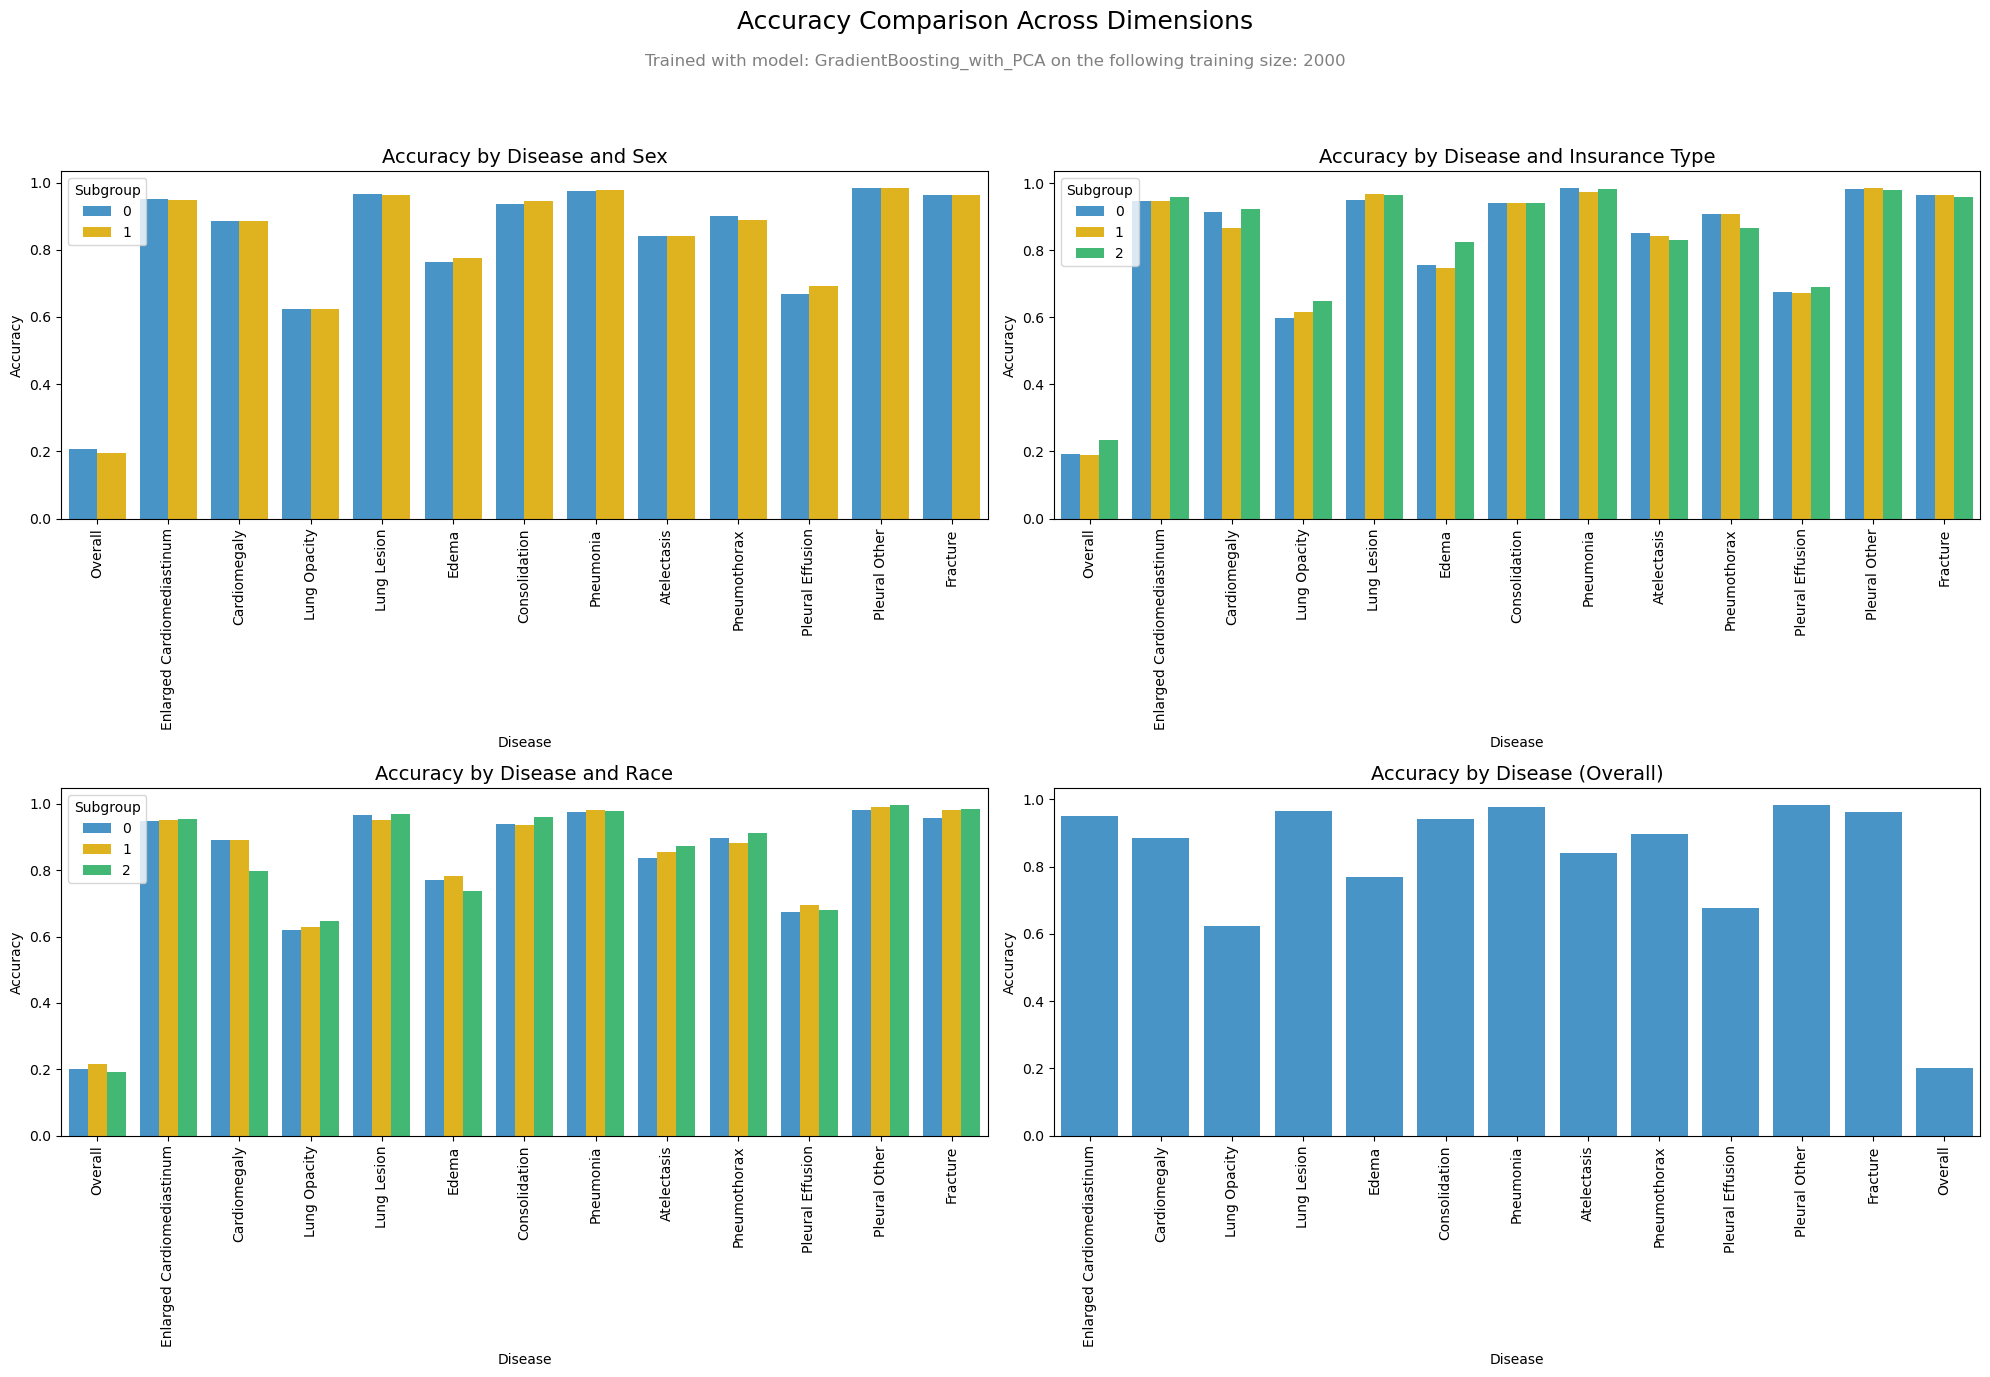

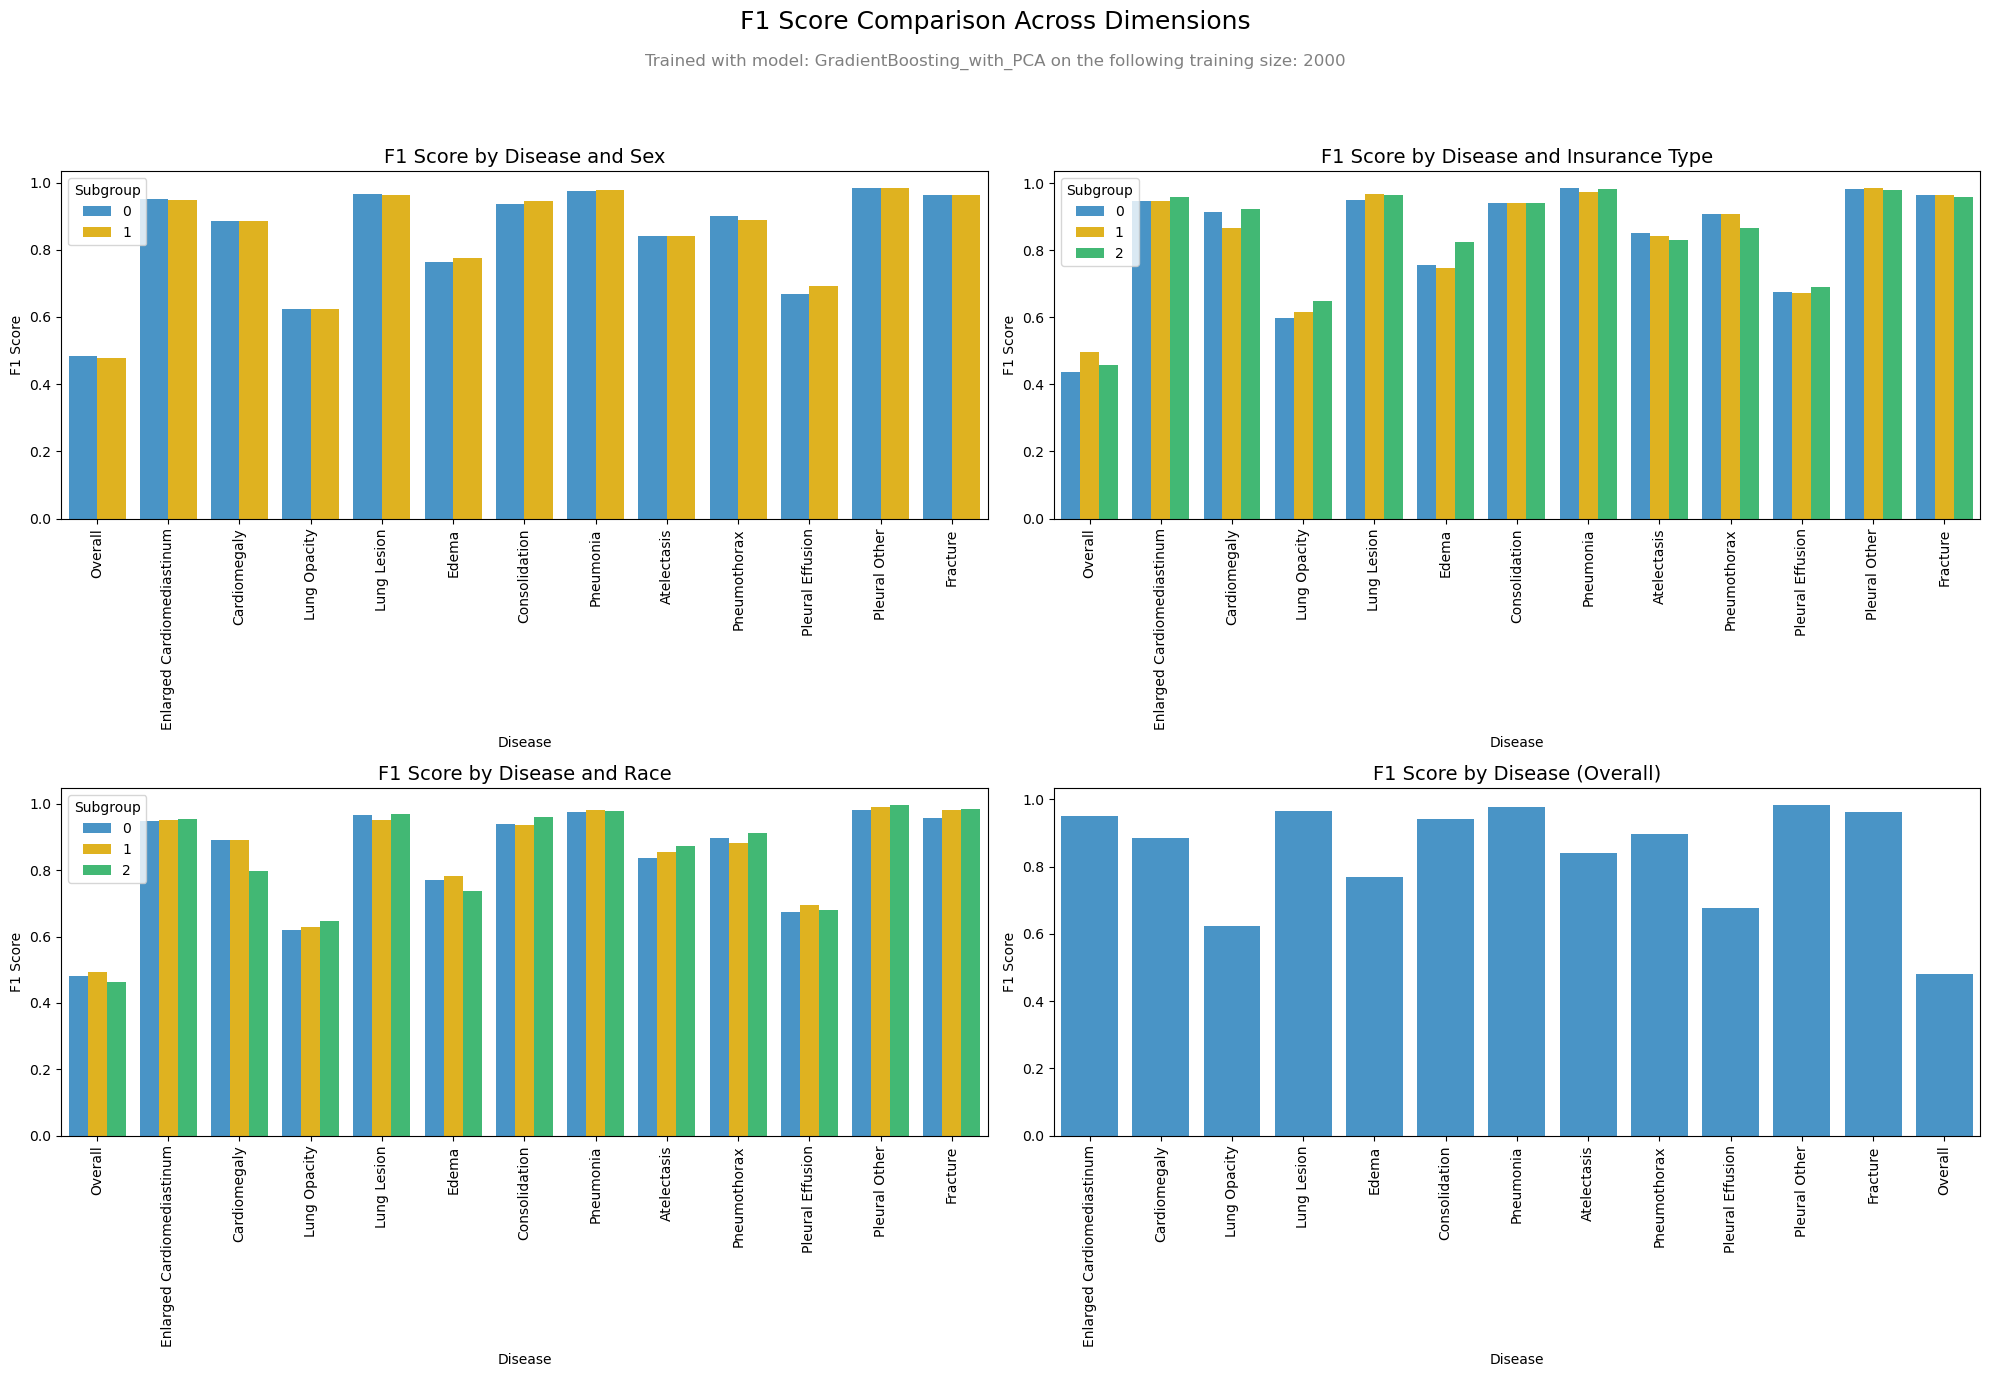

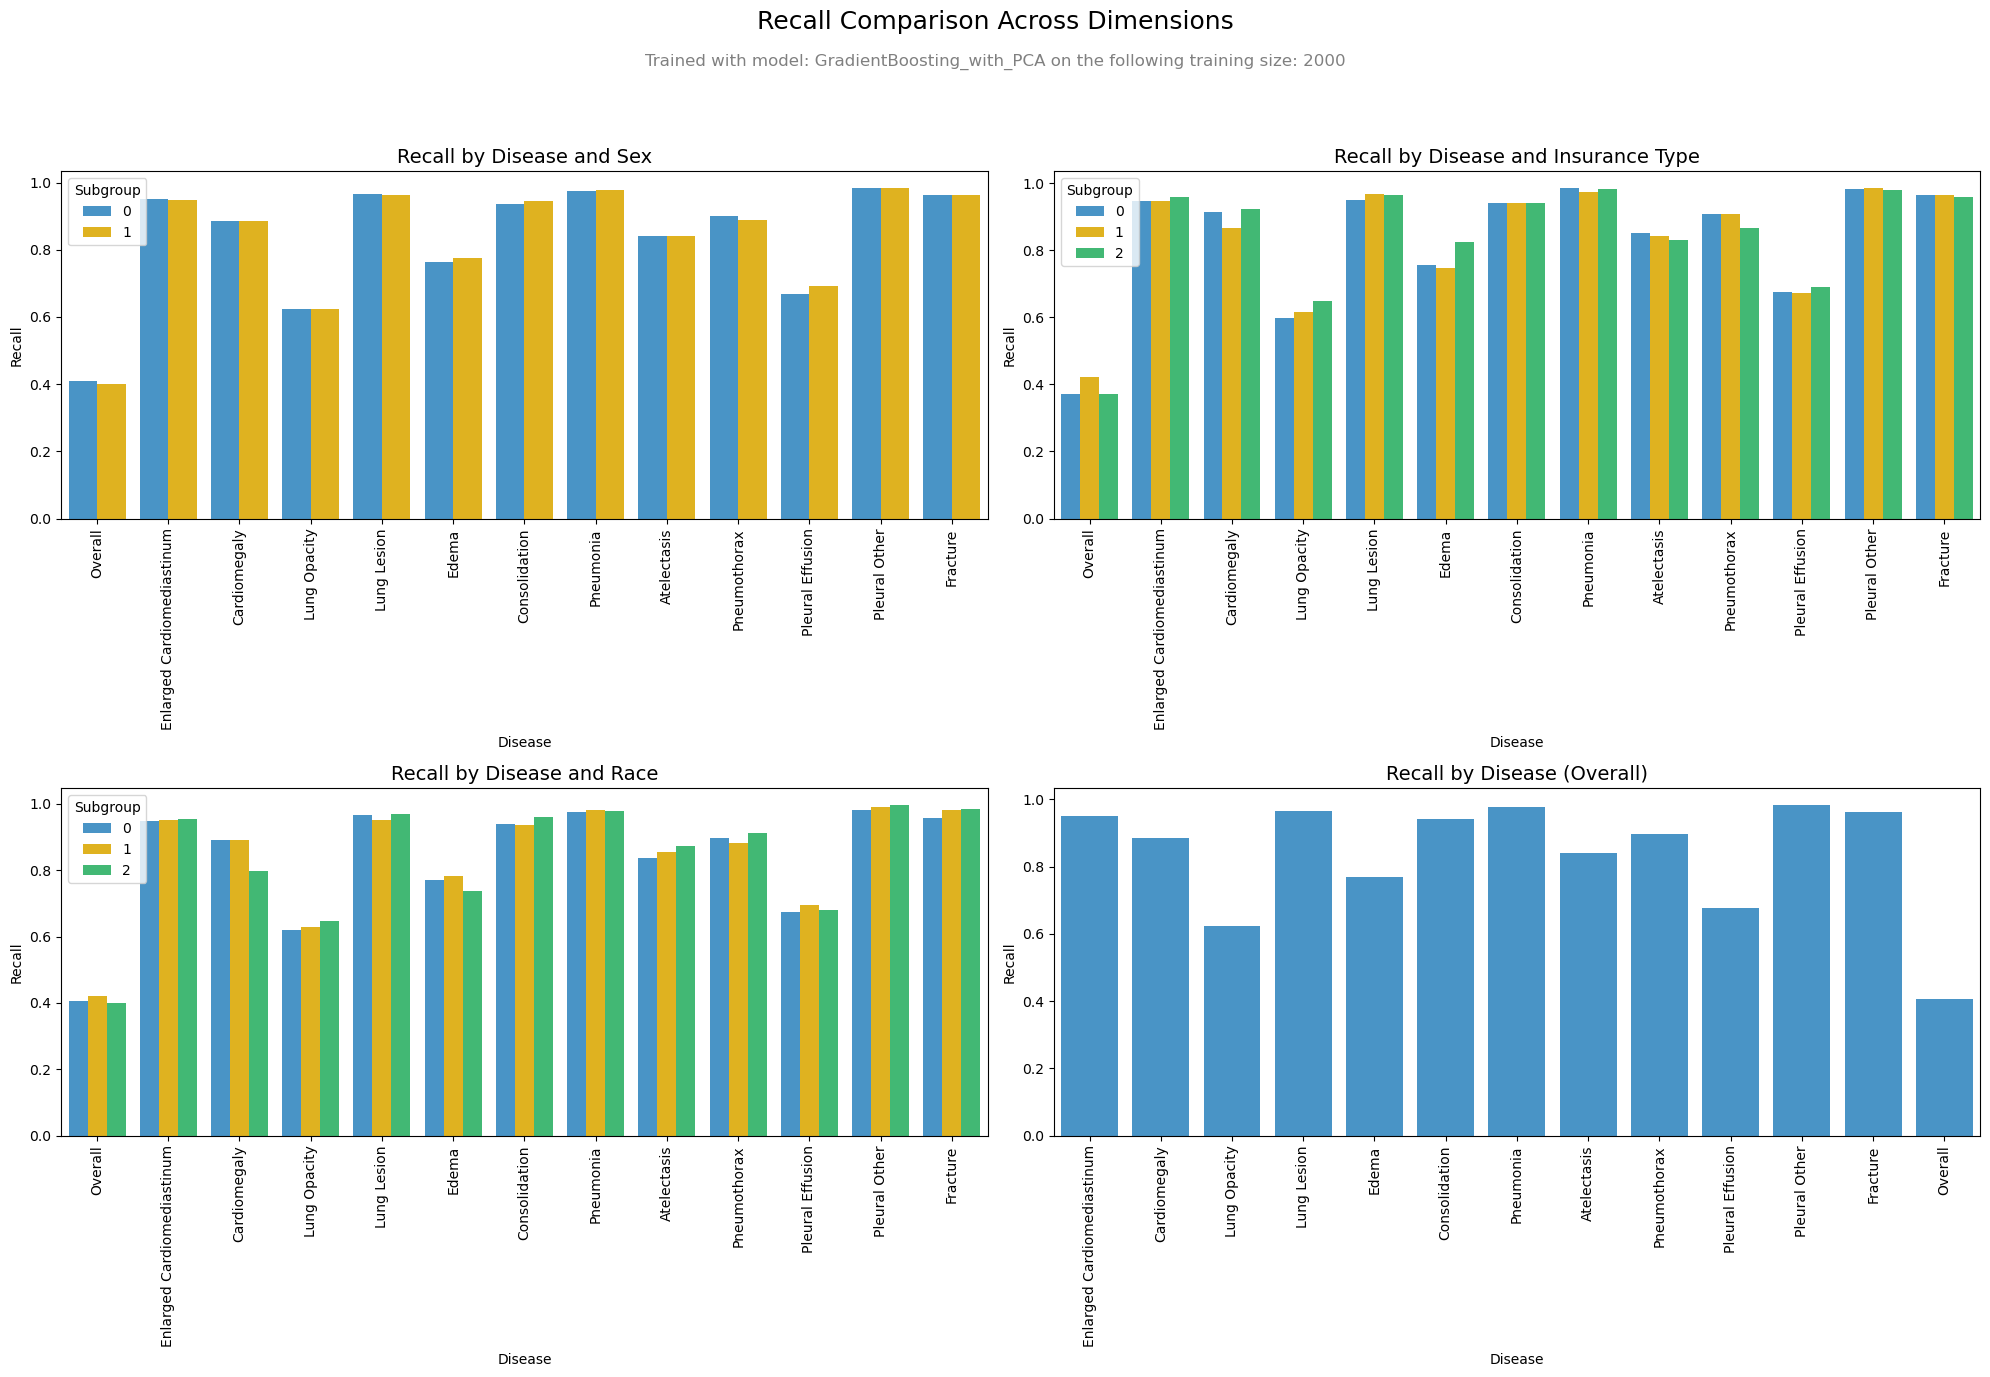

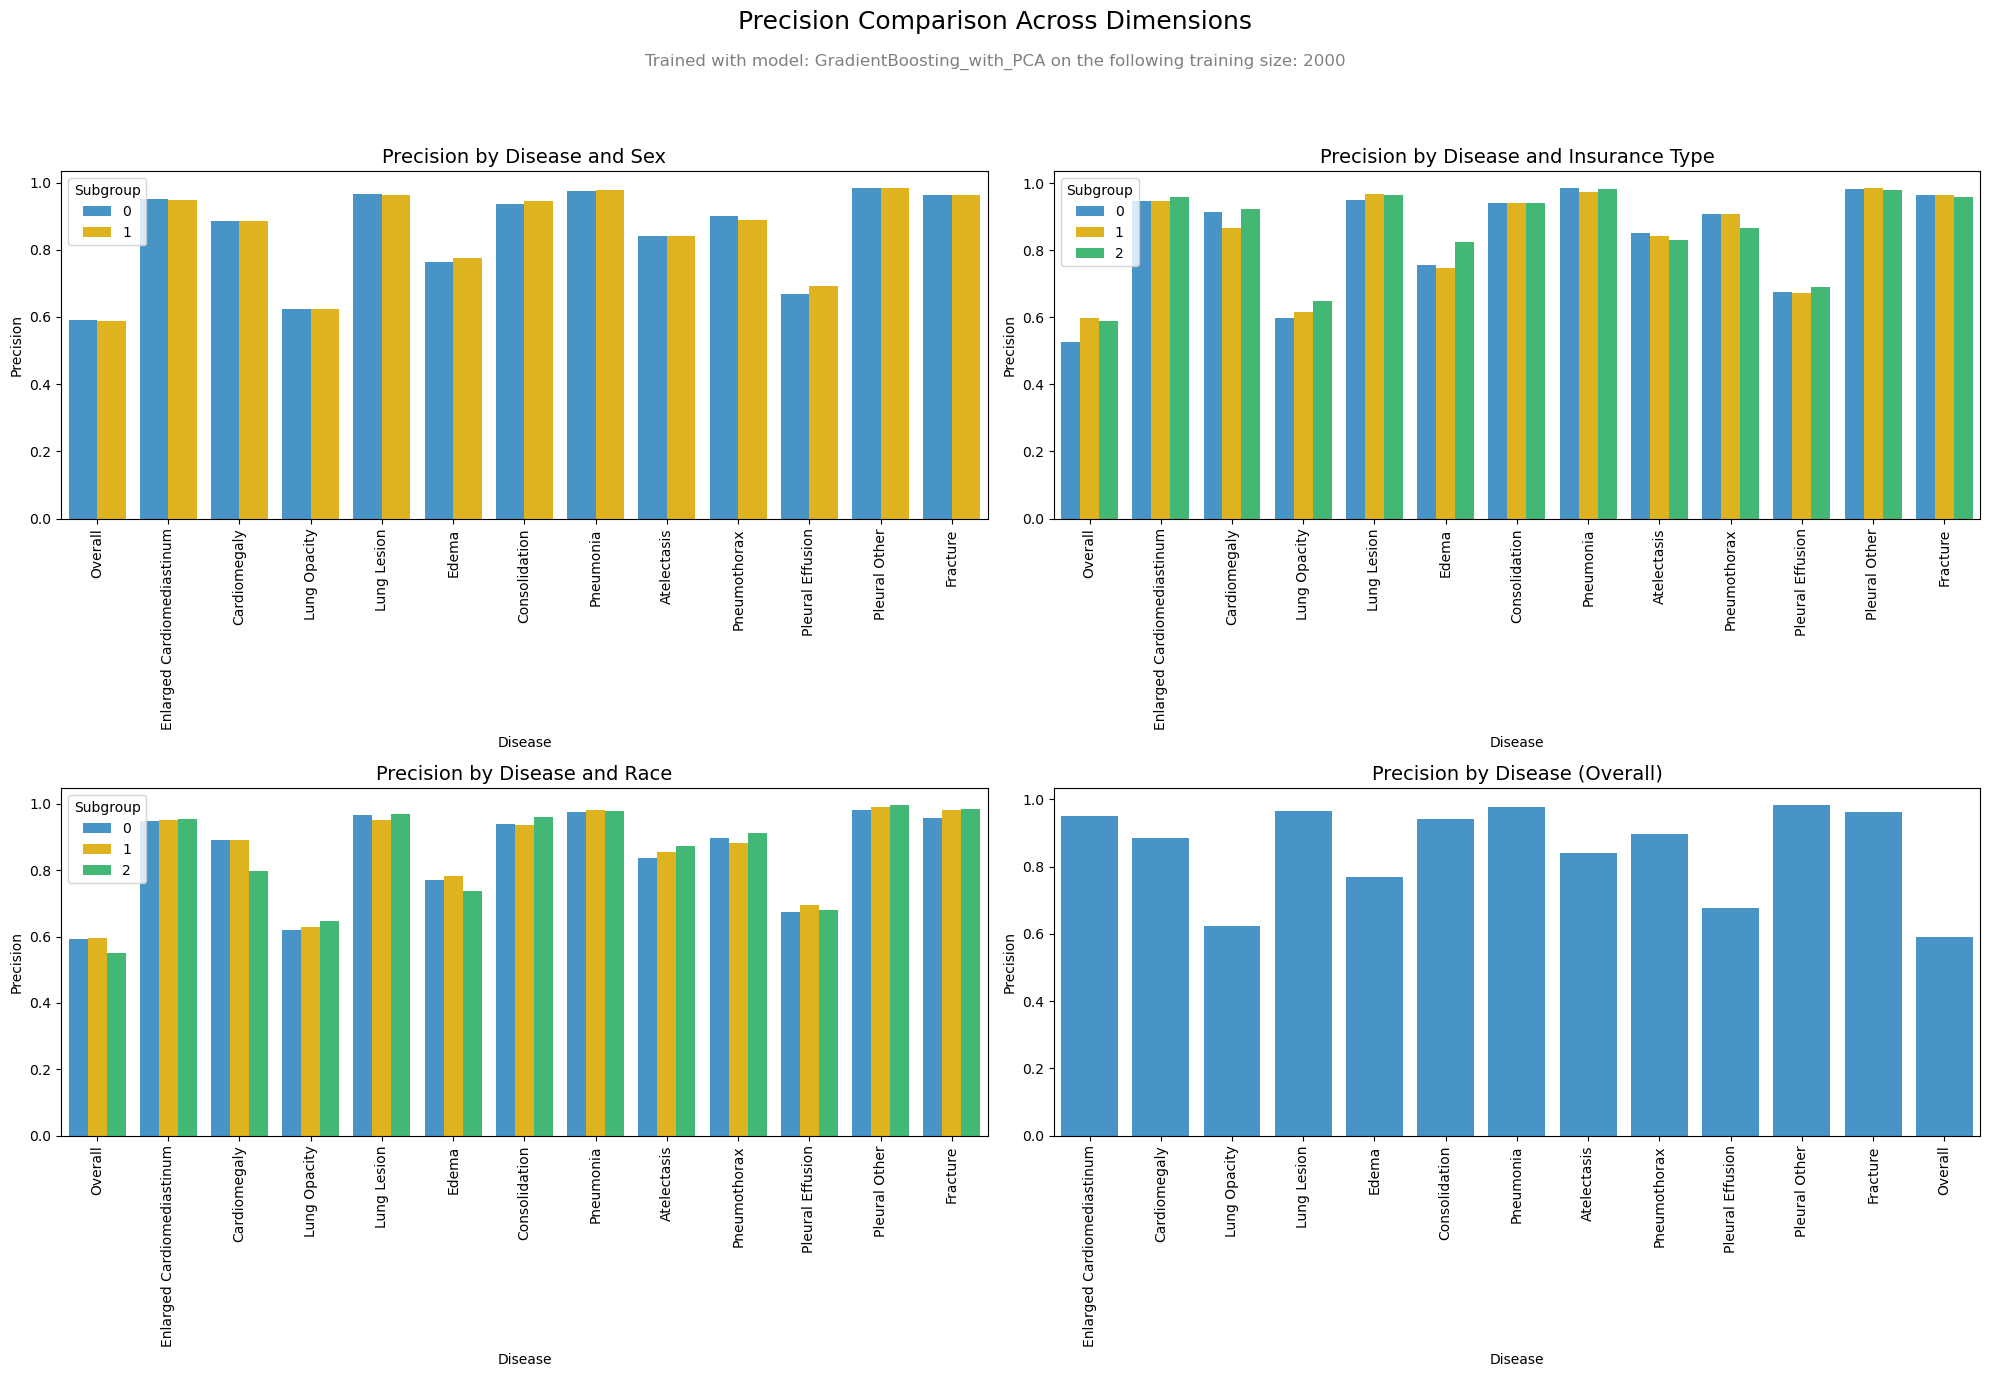

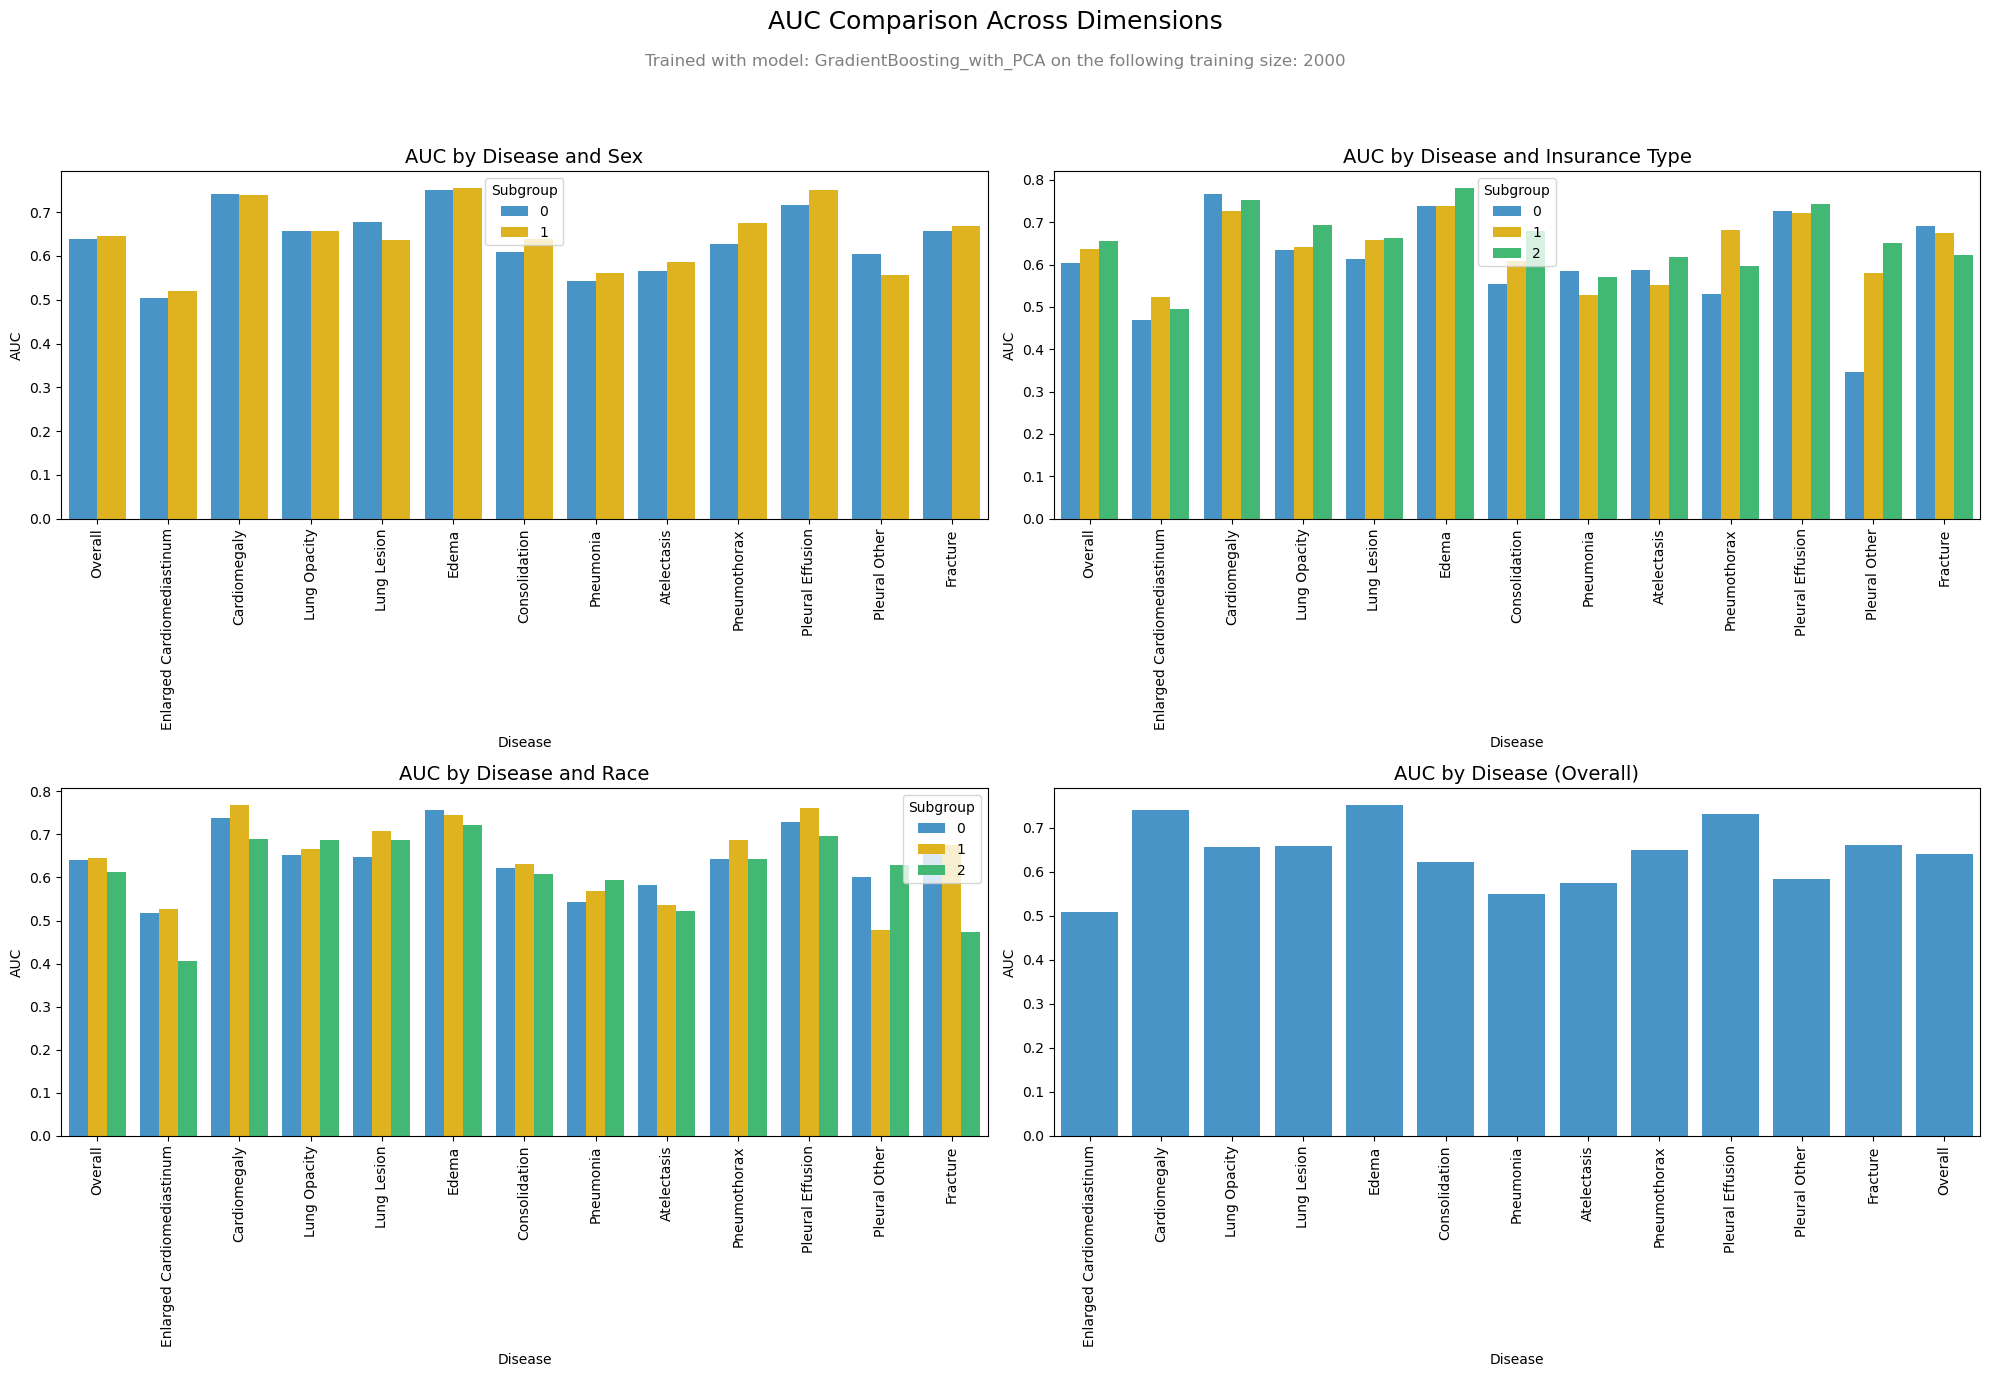

In [11]:
diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 
            'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
            'Pleural Effusion', 'Pleural Other', 'Fracture']

def train_model(x_train, y_train, x_test, y_test, model, metric_dimensions=[], columns_to_drop=[], n_components=None):
    multi_output_model = MultiOutputClassifier(model)
    x_test = x_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    x_train_subset = x_train.drop(columns=columns_to_drop, errors='ignore')
    x_test_subset = x_test.drop(columns=columns_to_drop, errors='ignore')
    
    # Apply PCA if wanted
    if n_components:
        pca = PCA(n_components=n_components)
        x_train_subset = pca.fit_transform(x_train_subset)
        x_test_subset = pca.transform(x_test_subset)
        print(f"PCA used with {n_components} components.")
    else:
        print("PCA not used.")

    metrics_data = {
        'Metric Dimension': [],
        'Subgroup': [],
        'Disease': [],
        'Accuracy': [],
        'F1 Score': [],
        'Recall': [], # = True Positive Rate
        'FPR': [],
        'Precision': [],
        'AUC': [],
    }

    def calculate_metrics(y_true, y_pred, y_pred_proba=None, disease_label="Overall"):
        """ Helper function to calculate metrics and add them to metrics_data """
        metrics_data['Metric Dimension'].append(metric_dim)
        metrics_data['Subgroup'].append(subgroup)
        metrics_data['Disease'].append(disease_label)
        metrics_data['Accuracy'].append(accuracy_score(y_true, y_pred))
        metrics_data['F1 Score'].append(f1_score(y_true, y_pred, average='micro'))
        metrics_data['Recall'].append(recall_score(y_true, y_pred, average='micro'))
        metrics_data['Precision'].append(precision_score(y_true, y_pred, average='micro'))
        if y_pred_proba is not None:
            try:
                auc = roc_auc_score(y_true, y_pred_proba)
            except ValueError: 
                auc = None
            metrics_data['AUC'].append(auc)
        else:
            metrics_data['AUC'].append(None)

        # Calculate FPR
        if isinstance(y_true, pd.Series):  # Single-label case
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = cm.ravel()
            fpr = fp / (fp + tn) if (fp + tn) > 0 else None
            metrics_data['FPR'].append(fpr)
        else:  # Multi-label case
            fprs = []
            for c in y_true.columns:
                cm = confusion_matrix(y_true[c], y_pred[c])
                if cm.shape == (2, 2):  # Ensure binary confusion matrix shape
                    tn, fp, fn, tp = cm.ravel()
                    fpr = fp / (fp + tn) if (fp + tn) > 0 else None
                else:
                    fpr = None  # Handle cases where FPR isn't defined
                fprs.append(fpr)
            
            mean_fpr = np.nanmean(fprs)  # Mean FPR across all columns
            metrics_data["FPR"].append(mean_fpr)


    try:
        multi_output_model.fit(x_train_subset, y_train)
        y_test_preds = pd.DataFrame(multi_output_model.predict(x_test_subset), columns=diseases)
        if hasattr(model, "predict_proba"):
            y_test_preds_proba = pd.DataFrame({disease: probs[:, 1] for disease, probs in zip(diseases, multi_output_model.predict_proba(x_test_subset))}) # Dataframe with probabilites 
        else:
            y_test_preds_proba = None

        metric_dim, subgroup = "all", "all"
        calculate_metrics(y_test, y_test_preds, y_test_preds_proba)

      
        
        # Calculate metrics for each disease individually
        for disease in diseases:
            y_true_disease = y_test[disease]
            y_pred_disease = y_test_preds[disease]
            y_pred_proba_disease = y_test_preds_proba[disease] if y_test_preds_proba is not None else None
            calculate_metrics(y_true_disease, y_pred_disease, y_pred_proba_disease, disease_label=disease)
    except ValueError:
        print("Multi-output not supported. Training each disease separately.")
        for disease in diseases:
            model.fit(x_train_subset, y_train[disease])
            y_test_preds = model.predict(x_test_subset)
            y_test_preds_proba = model.predict_proba(x_test_subset)[:, 1] if hasattr(model, "predict_proba") else None
            metric_dim, subgroup = "all", "all"
            calculate_metrics(y_test[disease], y_test_preds, y_test_preds_proba, disease_label=disease)

    # Calculate metrics for each dimension in `metric_dimensions` - in our case mostly sex, race, and insurance_type
    for metric_dim in metric_dimensions:
        for subgroup in x_test[metric_dim].unique(): #looks at every unique subgroup e.g. female and male 
            mask = (x_test[metric_dim] == subgroup) # here we only look at the rows where the subgroup e.g. female is True
            x_test_subgroup = x_test_subset[mask]
            y_test_subgroup = y_test.loc[mask]
            try:
                y_test_preds_subgroup = y_test_preds.loc[mask] # filtern of the predictions we made before just with that one subgroup
                y_test_preds_proba_subgroup = y_test_preds_proba.loc[mask] if y_test_preds_proba is not None else None # filters also if applicable the y_test_pred_proba for that subgorup and line?
                calculate_metrics(y_test_subgroup, y_test_preds_subgroup, y_test_preds_proba_subgroup)
                for disease in diseases:
                    y_true_subgroup_disease = y_test_subgroup[disease]
                    y_pred_subgroup_disease = y_test_preds_subgroup[disease]
                    y_pred_proba_subgroup_disease = y_test_preds_proba_subgroup[disease] if y_test_preds_proba_subgroup is not None else None
                    calculate_metrics(y_true_subgroup_disease, y_pred_subgroup_disease, y_pred_proba_subgroup_disease, disease_label=disease)
            except Exception:
                for disease in diseases:
                    y_test_subgroup_disease = y_test_subgroup[disease]
                    y_test_preds_disease = model.predict(x_test_subgroup)
                    y_test_preds_proba_disease = model.predict_proba(x_test_subgroup)[:, 1] if hasattr(model, "predict_proba") else None
                    calculate_metrics(y_test_subgroup_disease, y_test_preds_disease, y_test_preds_proba_disease, disease_label=disease)

    # Convert metrics_data to DataFrame and return
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df = metrics_df.reset_index(drop=True)
    print(metrics_df.columns) 
    return metrics_df

def plot_metrics(metrics_df, metric_name, modelname, trainingsize):
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))  # Größere Figur
    fig.suptitle(f"{metric_name} Comparison Across Dimensions", fontsize=18)
    fig.text(0.5, 0.94, f"Trained with model: {modelname} on the following training size: {trainingsize}", 
             ha='center', fontsize=12, color="gray")

    palette = ["#3498DB", "#FFC300", "#2ECC71", "#E74C3C"]
# Plot 1: Metric by Disease for each Sex
    sex_data = metrics_df[metrics_df['Metric Dimension'] == 'sex']
    sns.barplot(data=sex_data, x='Disease', y=metric_name, hue='Subgroup', ax=axes[0, 0], palette=palette[:2])
    axes[0, 0].set_title(f"{metric_name} by Disease and Sex", fontsize=14)
    axes[0, 0].tick_params(axis='x', rotation=90)
    
    # Plot 2: Metric by Disease for each Insurance_Type
    insurance_data = metrics_df[metrics_df['Metric Dimension'] == 'insurance_type']
    sns.barplot(data=insurance_data, x='Disease', y=metric_name, hue='Subgroup', ax=axes[0, 1], palette=palette[:3])
    axes[0, 1].set_title(f"{metric_name} by Disease and Insurance Type", fontsize=14)
    axes[0, 1].tick_params(axis='x', rotation=90)  
    
    # Plot 3: Metric by Disease for each Race
    race_data = metrics_df[metrics_df['Metric Dimension'] == 'race']
    sns.barplot(data=race_data, x='Disease', y=metric_name, hue='Subgroup', ax=axes[1, 0], palette=palette[:3])  
    axes[1, 0].set_title(f"{metric_name} by Disease and Race", fontsize=14)
    axes[1, 0].tick_params(axis='x', rotation=90)  
    
    # Plot 4: Overall Metric by Disease (no subgroups)
    overall_disease_data = metrics_df[(metrics_df['Metric Dimension'] == 'all') & (metrics_df['Disease'] != 'Overall')]
    overall_metric = metrics_df[(metrics_df['Metric Dimension'] == 'all') & (metrics_df['Disease'] == 'Overall')]
    # Add the overall metric as a new row in the DataFrame for plotting
    if not overall_metric.empty:
        overall_row = pd.DataFrame({
            'Disease': ['Overall'], 
            metric_name: [overall_metric[metric_name].values[0]]  # Accuracy over all diseases
        })
        overall_disease_data = pd.concat([overall_disease_data, overall_row], ignore_index=True)

    # Plot the data including the "Overall" bar
    sns.barplot(data=overall_disease_data, x='Disease', y=metric_name, ax=axes[1, 1], color=palette[0])
    axes[1, 1].set_title(f"{metric_name} by Disease (Overall)", fontsize=14)
    axes[1, 1].tick_params(axis='x', rotation=90)
    plt.subplots_adjust(wspace=0.1, hspace=0.3)  
    plt.tight_layout(rect=[0, 0, 1, 0.92])  
    plt.savefig(f"ml_plots/{metric_name}_{modelname}_{trainingsize}_comparison.png", bbox_inches='tight')
    plt.show()

training_size = 2000
use_pca = True        
n_components = 10     

xgb_model = XGBClassifier(
    use_label_encoder=False,      
    eval_metric='logloss',   
    learning_rate=0.1,
    n_estimators=30,
    random_state=42
)
xgb_metrics = train_model(
    x_train=x_train.iloc[:training_size], 
    y_train=y_train.iloc[:training_size], 
    x_test=x_test, 
    y_test=y_test, 
    model=xgb_model, 
    metric_dimensions=["sex", "race", "insurance_type"],
    n_components=n_components 
)

# rcf = RandomForestClassifier(n_estimators=30, random_state=42)
# rcf_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=rcf, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=n_components   
# )

# # Naive Bayes
# naive_bayes = MultinomialNB()
# nb_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=naive_bayes, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=None  
# )

# # Gradient Boosting
# xgb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30, verbose=1, random_state=42, n_iter_no_change=5)
# xgb_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=xgb, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=n_components   
# )

# # Decision Tree
# dct = DecisionTreeClassifier(random_state=42)
# dct_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=dct, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=n_components 
# )

# Plotting
for metric in ['Accuracy', 'F1 Score', 'Recall', 'Precision','AUC']:
    #plot_metrics(rcf_metrics, metric, "RandomForest_with_PCA" , str(training_size))
    #plot_metrics(nb_metrics, metric, "NaiveBayes", str(training_size))
    plot_metrics(xgb_metrics, metric, "GradientBoosting_with_PCA" , str(training_size))
    # plot_metrics(dct_metrics, metric, "DecisionTree_with_PCA", str(training_size))


In [12]:
xgb_metrics.head(10)

,Metric Dimension,Subgroup,Disease,Accuracy,F1 Score,Recall,FPR,Precision,AUC
0,all,all,Overall,0.201518,0.481350,0.406518,0.073870,0.589948,0.640659
1,all,all,Enlarged Cardiomediastinum,0.950011,0.950011,0.950011,0.000000,0.950011,0.509282
2,all,all,Cardiomegaly,0.885070,0.885070,0.885070,0.016826,0.885070,0.740315
3,all,all,Lung Opacity,0.622852,0.622852,0.622852,0.482821,0.622852,0.657043
4,all,all,Lung Lesion,0.964294,0.964294,0.964294,0.000000,0.964294,0.659622
5,all,all,Edema,0.768802,0.768802,0.768802,0.061493,0.768802,0.752103
6,all,all,Consolidation,0.940638,0.940638,0.940638,0.000000,0.940638,0.621570
7,all,all,Pneumonia,0.976345,0.976345,0.976345,0.000000,0.976345,0.548431
8,all,all,Atelectasis,0.840884,0.840884,0.840884,0.001060,0.840884,0.574924
9,all,all,Pneumothorax,0.896229,0.896229,0.896229,0.002237,0.896229,0.650086


In [13]:
def calculate_delta_auc(metrics_df):

    df_agg = metrics_df[metrics_df["Metric Dimension"] != "all"].groupby(["Metric Dimension", "Disease"], as_index=False).apply(
        lambda x: pd.Series({
            "delta_AUC": (np.max(x["AUC"]) - np.min(x["AUC"])),
            "eqOdds": 1/2 * (np.max(x["Recall"]) - np.min(x["Recall"]) ) + 1/2 * (np.max(x["FPR"]) - np.min(x["FPR"]) )
        })
        
    )
    
    
    return df_agg

fairness_metrics = calculate_delta_auc(xgb_metrics)



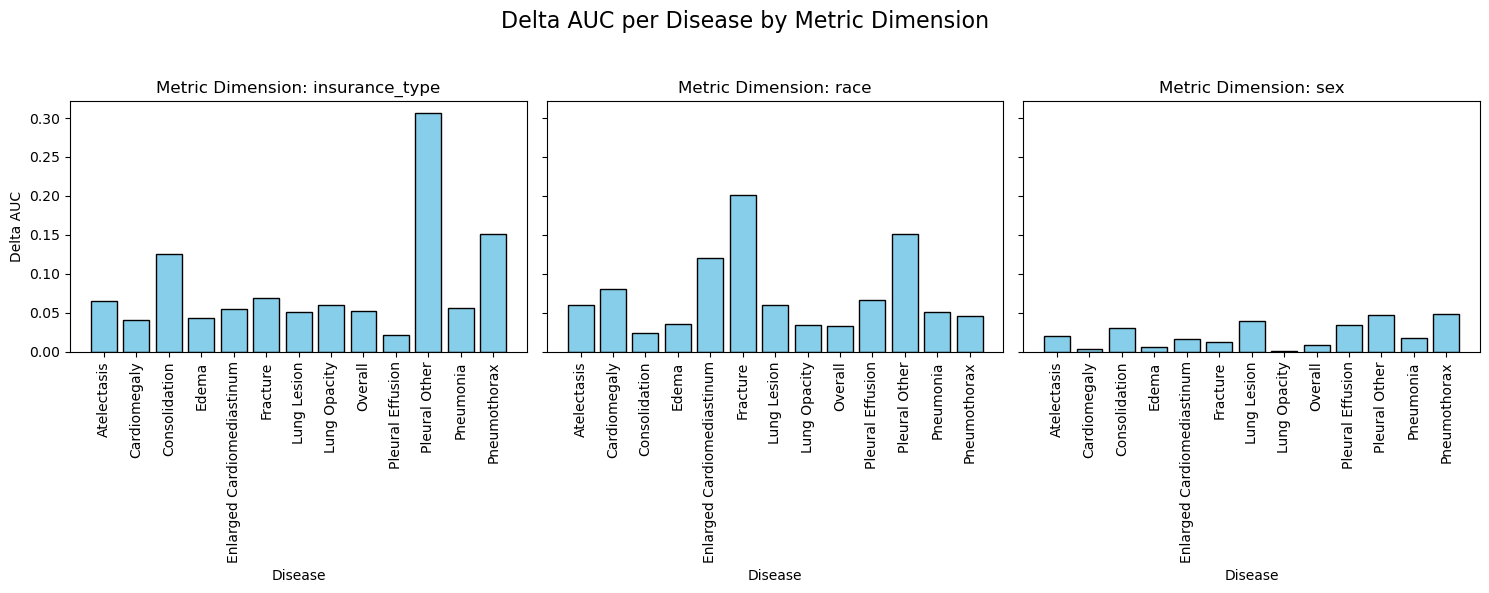

In [14]:
# Extract unique metric dimensions
metric_dimensions = fairness_metrics['Metric Dimension'].unique()

# Set up the plot
fig, axes = plt.subplots(1, len(metric_dimensions), figsize=(15, 6), sharey=True)
fig.suptitle("Delta AUC per Disease by Metric Dimension", fontsize=16)

# Iterate over each metric dimension to create a subplot
for i, metric_dim in enumerate(metric_dimensions):
    # Filter the DataFrame for the current metric dimension
    subset = fairness_metrics[fairness_metrics['Metric Dimension'] == metric_dim]
    
    # Plot the delta_AUC for each disease within the current metric dimension
    axes[i].bar(subset['Disease'], subset['delta_AUC'], color='skyblue', edgecolor='black')
    axes[i].set_title(f"Metric Dimension: {metric_dim}")
    axes[i].set_xlabel("Disease")
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Set common y-axis label and layout adjustments
axes[0].set_ylabel("Delta AUC")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for title
plt.show()

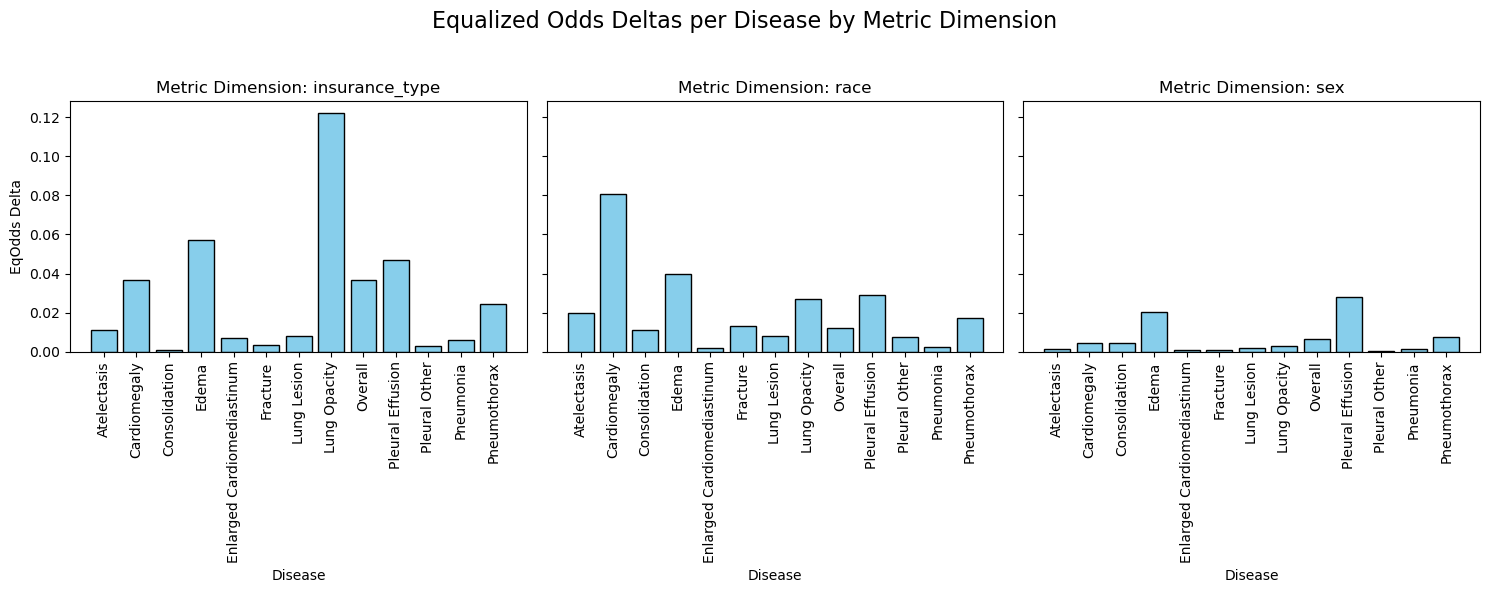

In [15]:
# Extract unique metric dimensions
metric_dimensions = fairness_metrics['Metric Dimension'].unique()

# Set up the plot
fig, axes = plt.subplots(1, len(metric_dimensions), figsize=(15, 6), sharey=True)
fig.suptitle("Equalized Odds Deltas per Disease by Metric Dimension", fontsize=16)

# Iterate over each metric dimension to create a subplot
for i, metric_dim in enumerate(metric_dimensions):
    # Filter the DataFrame for the current metric dimension
    subset = fairness_metrics[fairness_metrics['Metric Dimension'] == metric_dim]
    
    # Plot the eqOdds for each disease within the current metric dimension
    axes[i].bar(subset['Disease'], subset['eqOdds'], color='skyblue', edgecolor='black')
    axes[i].set_title(f"Metric Dimension: {metric_dim}")
    axes[i].set_xlabel("Disease")
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Set common y-axis label and layout adjustments
axes[0].set_ylabel("EqOdds Delta")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for title
plt.show()

PCA used with 10 components.


/Users/svea/miniconda3/envs/mitigate-bias/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [18:21:45] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/svea/miniconda3/envs/mitigate-bias/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [18:21:46] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Index(['Metric Dimension', 'Subgroup', 'Disease', 'Accuracy', 'F1 Score',
       'Recall', 'FPR', 'Precision', 'AUCPR'],
      dtype='object')


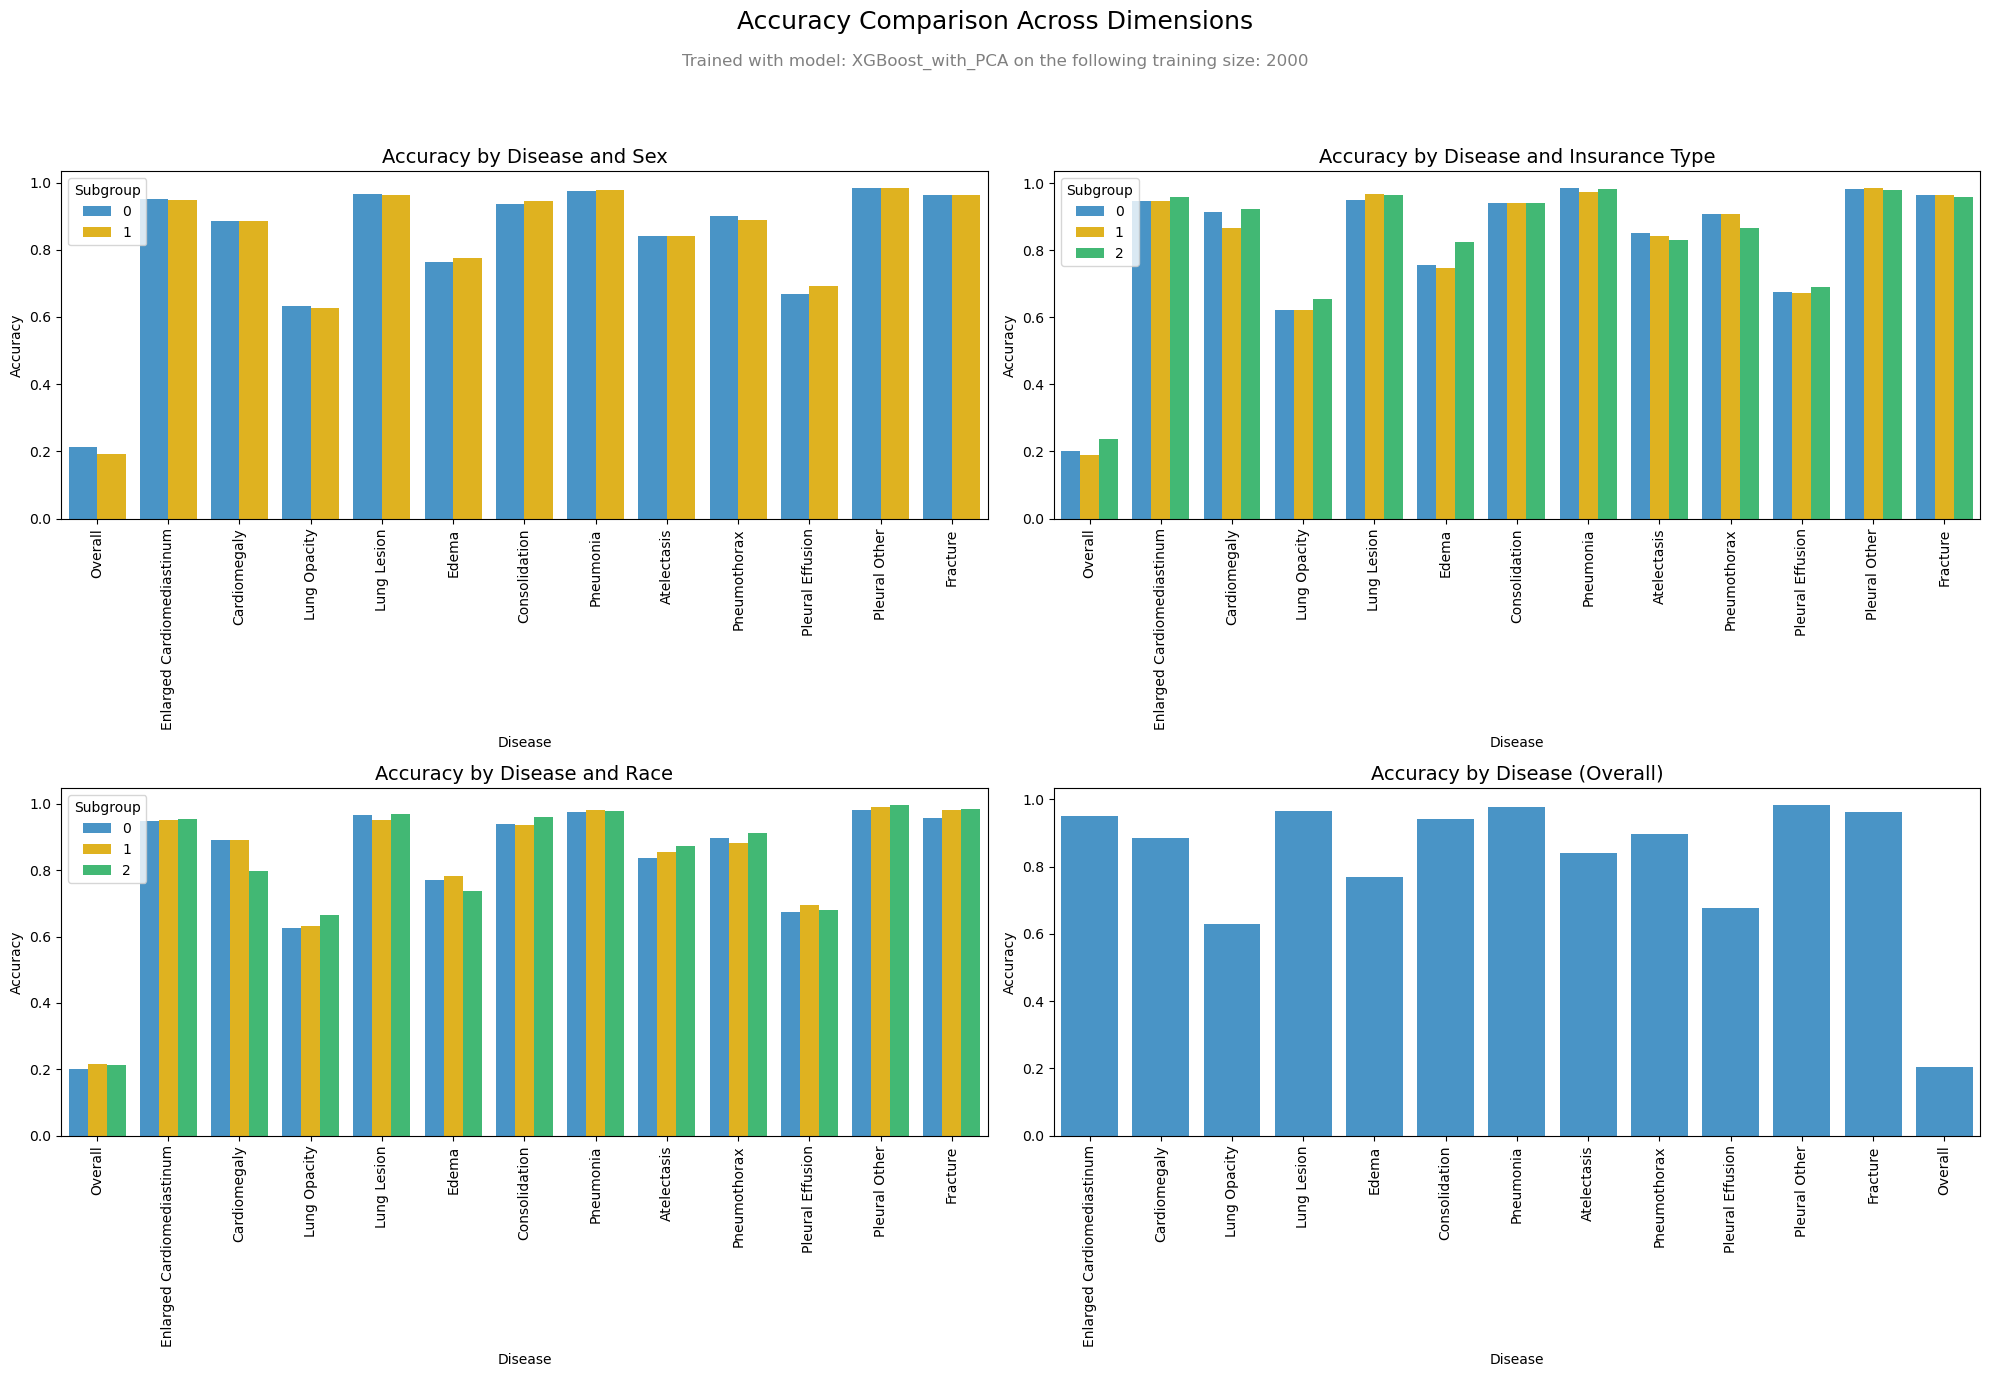

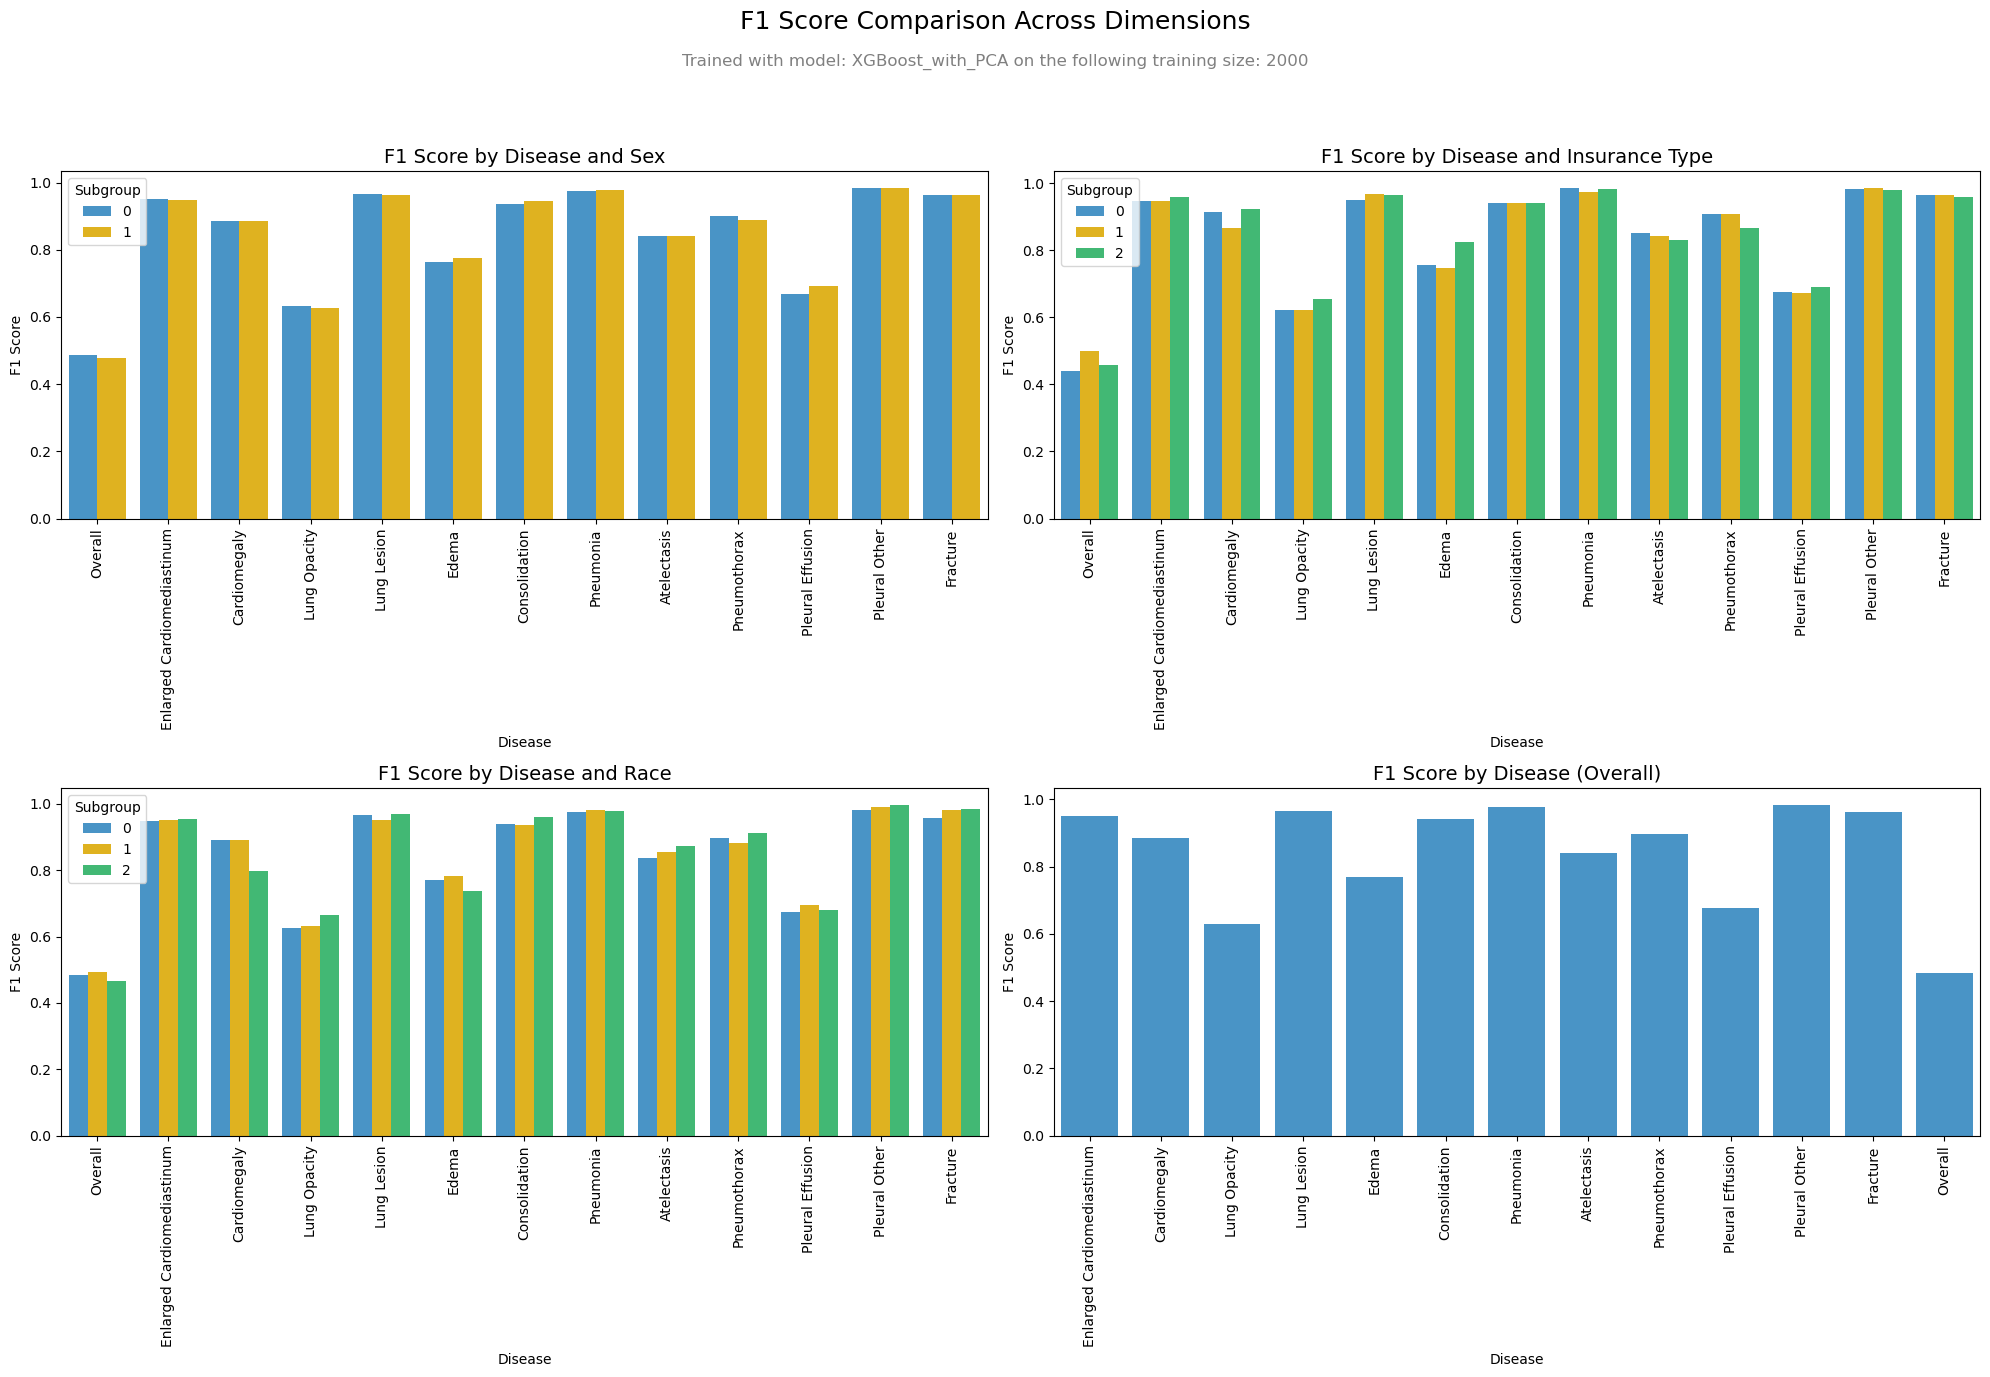

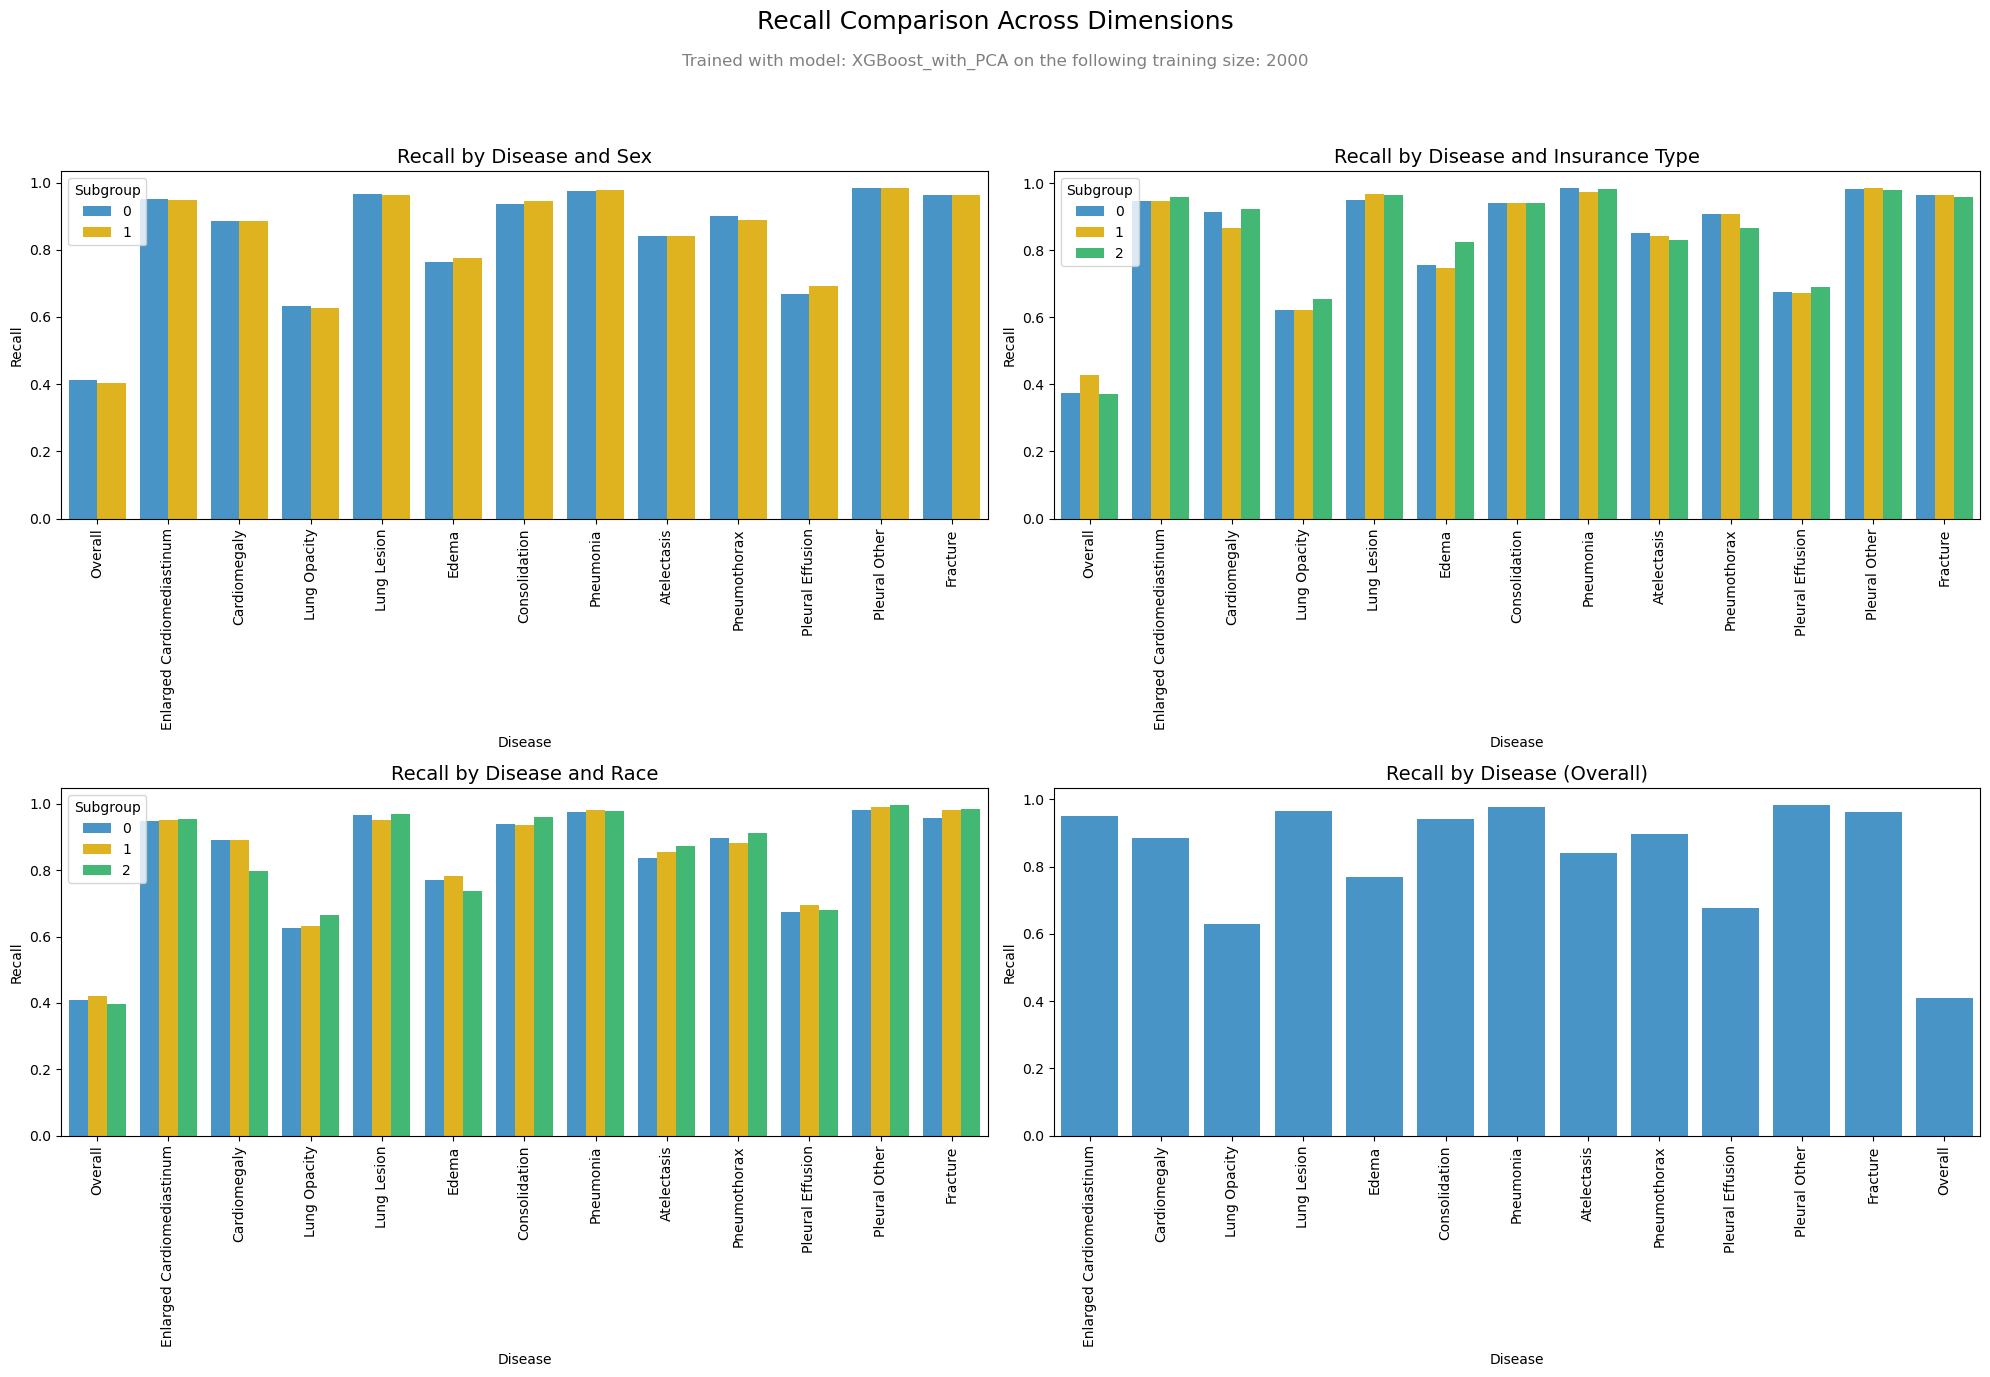

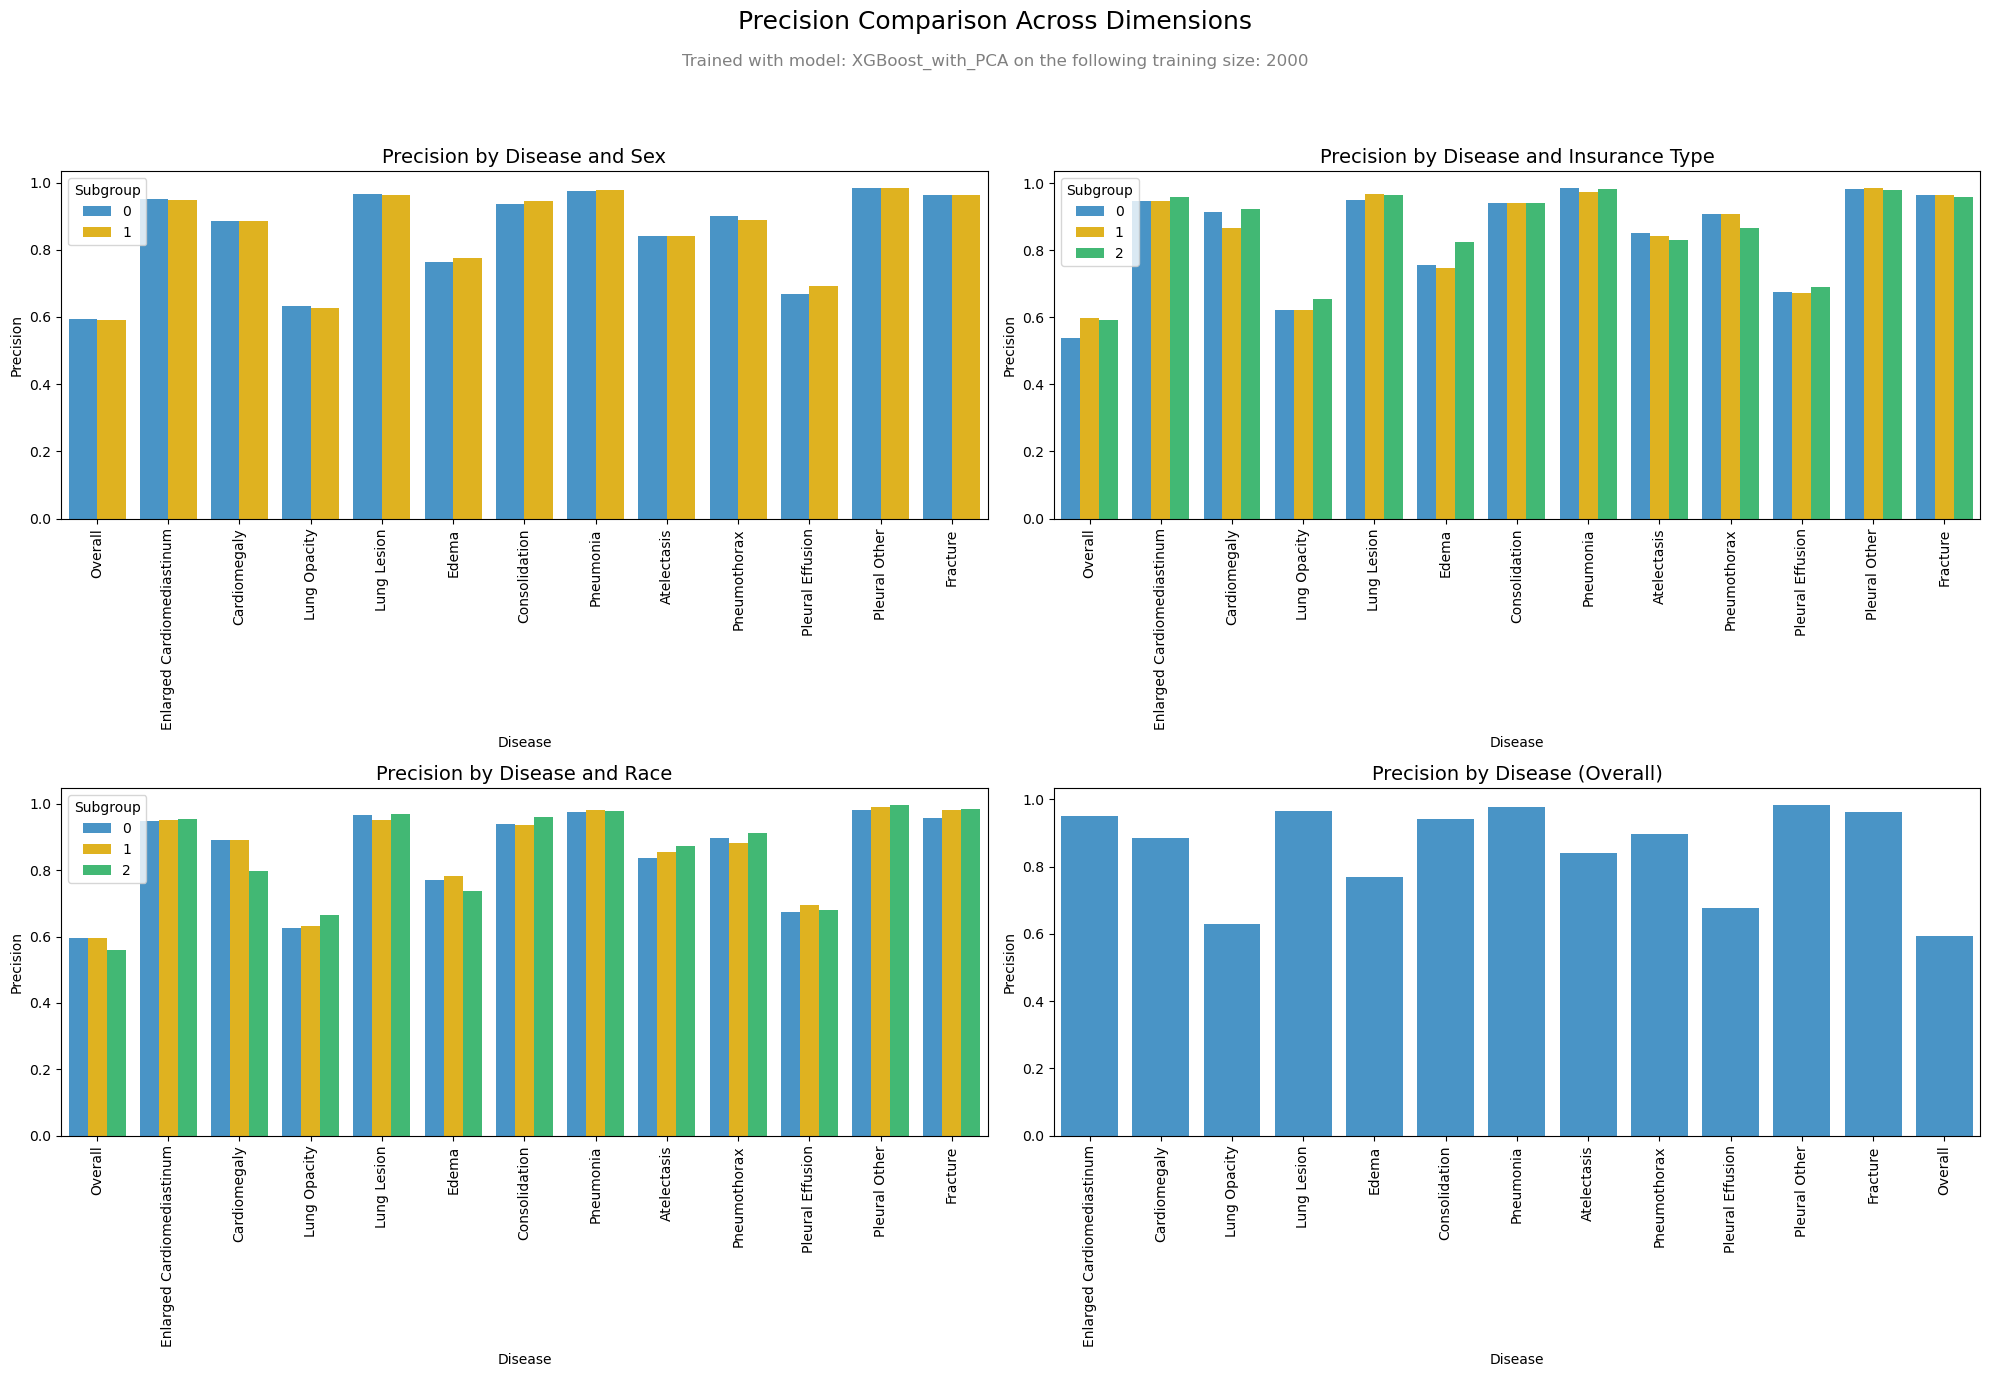

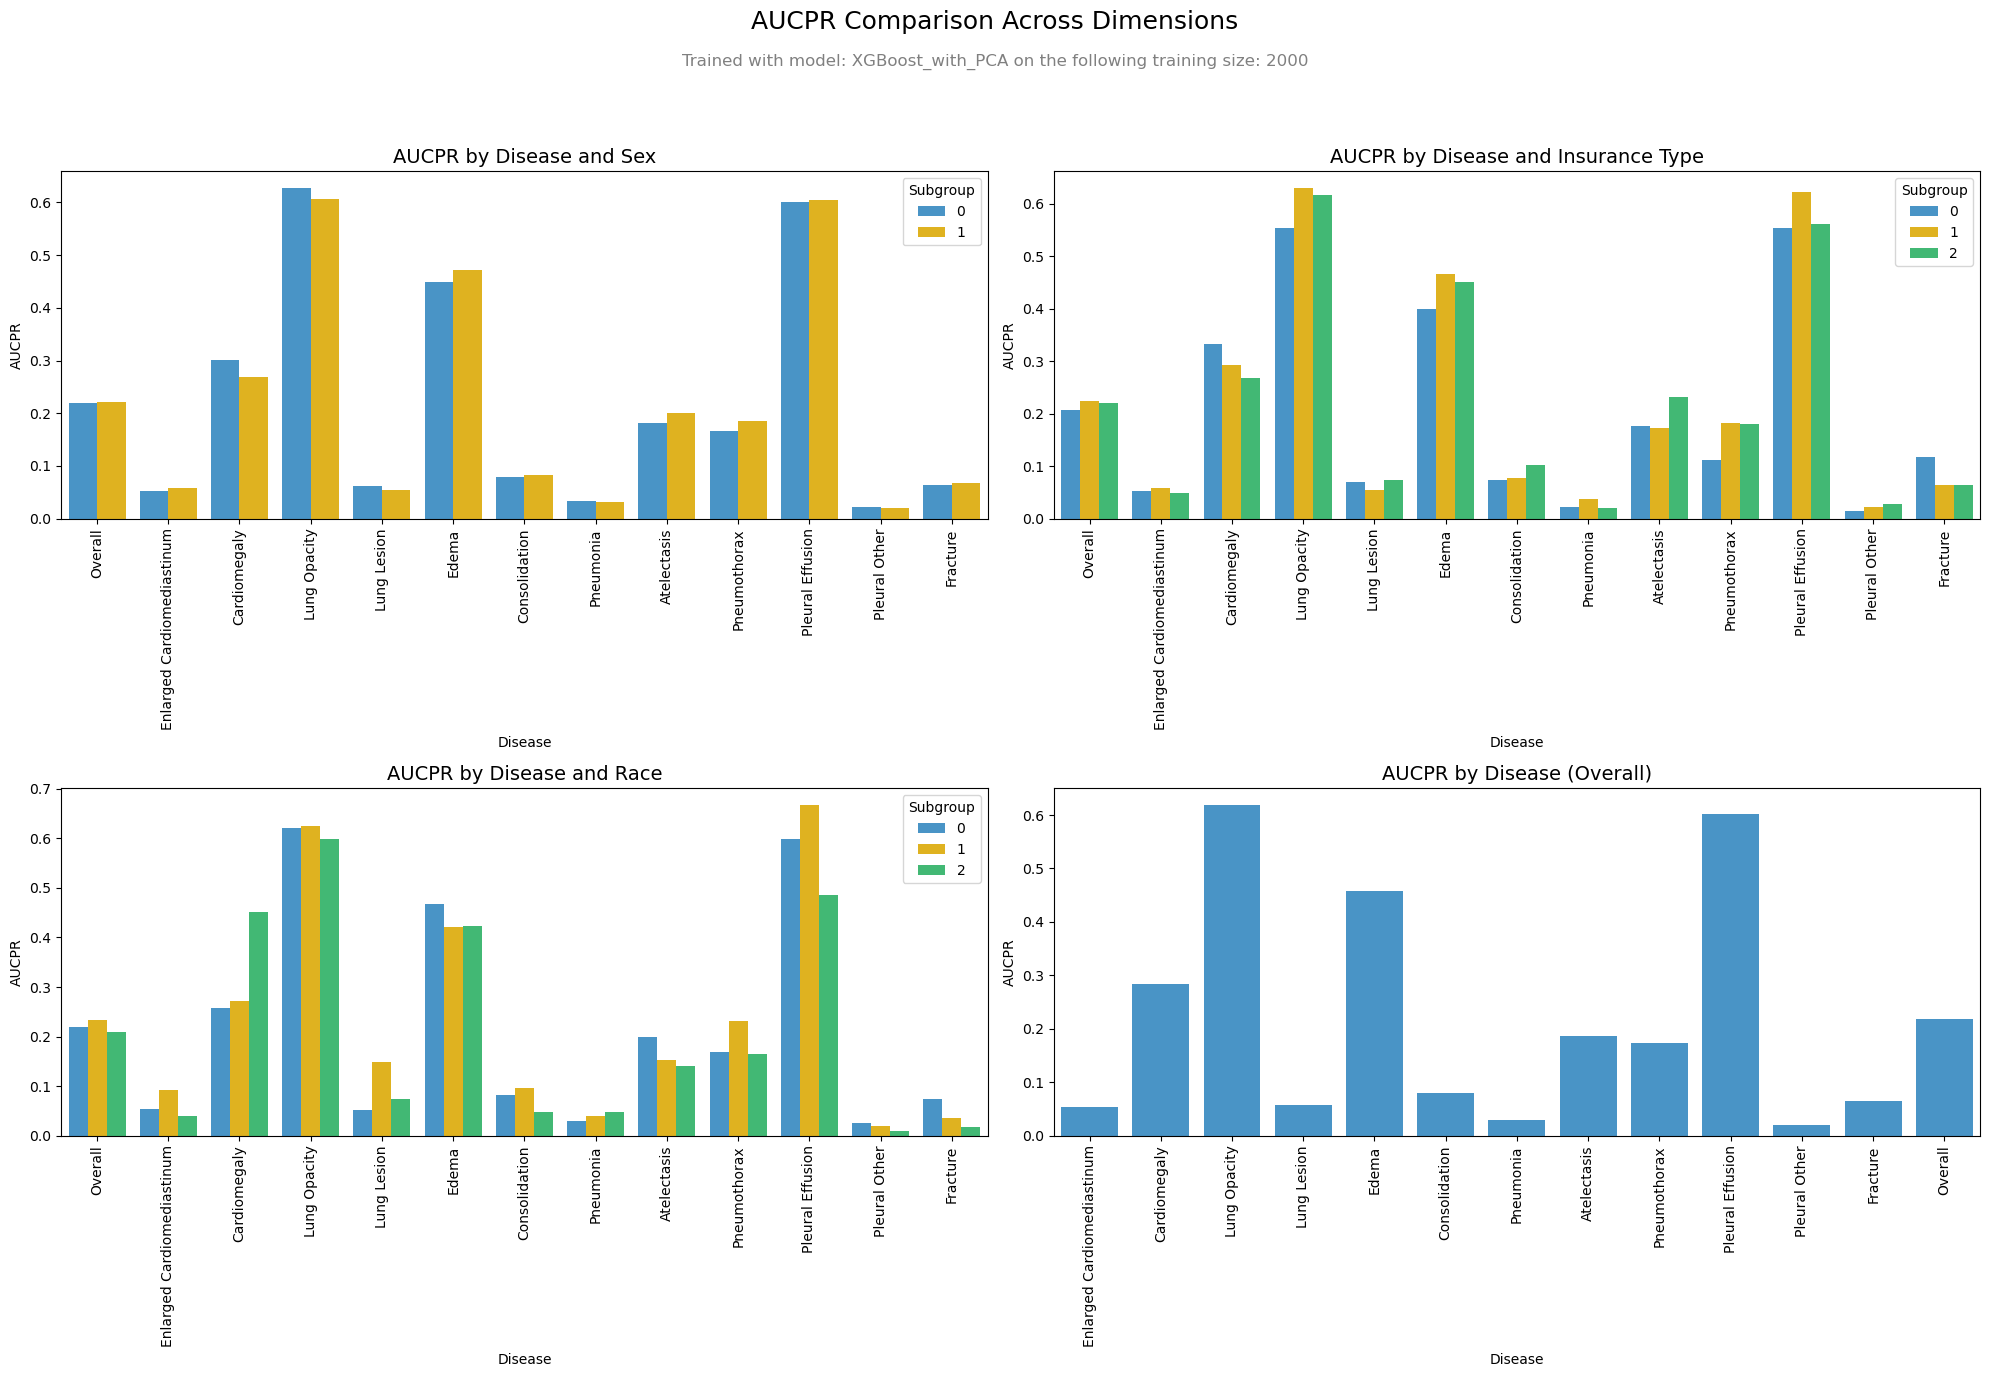

In [16]:
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, average_precision_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Liste der Krankheiten
diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 
            'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
            'Pleural Effusion', 'Pleural Other', 'Fracture']

def train_model(x_train, y_train, x_test, y_test, model, metric_dimensions=[], columns_to_drop=[], n_components=None):
    multi_output_model = MultiOutputClassifier(model)
    x_test = x_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    x_train_subset = x_train.drop(columns=columns_to_drop, errors='ignore')
    x_test_subset = x_test.drop(columns=columns_to_drop, errors='ignore')
    
    # Apply PCA if wanted
    if n_components:
        pca = PCA(n_components=n_components)
        x_train_subset = pca.fit_transform(x_train_subset)
        x_test_subset = pca.transform(x_test_subset)
        print(f"PCA used with {n_components} components.")
    else:
        print("PCA not used.")

    metrics_data = {
        'Metric Dimension': [],
        'Subgroup': [],
        'Disease': [],
        'Accuracy': [],
        'F1 Score': [],
        'Recall': [],  # = True Positive Rate
        'FPR': [],
        'Precision': [],
        'AUCPR': [],
    }

    def calculate_metrics(y_true, y_pred, y_pred_proba=None, disease_label="Overall"):
        """ Helper function to calculate metrics and add them to metrics_data """
        metrics_data['Metric Dimension'].append(metric_dim)
        metrics_data['Subgroup'].append(subgroup)
        metrics_data['Disease'].append(disease_label)
        metrics_data['Accuracy'].append(accuracy_score(y_true, y_pred))
        metrics_data['F1 Score'].append(f1_score(y_true, y_pred, average='micro'))
        metrics_data['Recall'].append(recall_score(y_true, y_pred, average='micro'))
        metrics_data['Precision'].append(precision_score(y_true, y_pred, average='micro'))
        
        if y_pred_proba is not None:
            try:
                aucpr = average_precision_score(y_true, y_pred_proba)
            except ValueError: 
                aucpr = None
            metrics_data['AUCPR'].append(aucpr)
        else:
            metrics_data['AUCPR'].append(None)

        # Calculate FPR
        if isinstance(y_true, pd.Series):  # Single-label case
            cm = confusion_matrix(y_true, y_pred)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                fpr = fp / (fp + tn) if (fp + tn) > 0 else None
            else:
                fpr = None
            metrics_data['FPR'].append(fpr)
        else:  # Multi-label case
            if disease_label == "Overall":
                fprs = []
                for c in y_true.columns:
                    cm = confusion_matrix(y_true[c], y_pred[c])
                    if cm.shape == (2, 2):
                        tn, fp, fn, tp = cm.ravel()
                        fpr = fp / (fp + tn) if (fp + tn) > 0 else None
                        fprs.append(fpr)
                overall_fpr = np.nanmean(fprs) if fprs else None  # Mean FPR across all diseases
                metrics_data["FPR"].append(overall_fpr)
            else:
                # For individual diseases, append single FPR
                cm = confusion_matrix(y_true, y_pred)
                if cm.shape == (2, 2):
                    tn, fp, fn, tp = cm.ravel()
                    fpr = fp / (fp + tn) if (fp + tn) > 0 else None
                else:
                    fpr = None
                metrics_data["FPR"].append(fpr)

    try:
        multi_output_model.fit(x_train_subset, y_train)
        y_test_preds = pd.DataFrame(multi_output_model.predict(x_test_subset), columns=diseases)
        if hasattr(model, "predict_proba"):
            # multi_output_model.predict_proba returns a list of arrays, one for each class
            y_test_preds_proba = pd.DataFrame({disease: probs[:, 1] for disease, probs in zip(diseases, multi_output_model.predict_proba(x_test_subset))}) # Dataframe with probabilities 
        else:
            y_test_preds_proba = None

        metric_dim, subgroup = "all", "all"
        calculate_metrics(y_test, y_test_preds, y_test_preds_proba)

        # Calculate metrics for each disease individually
        for disease in diseases:
            y_true_disease = y_test[disease]
            y_pred_disease = y_test_preds[disease]
            y_pred_proba_disease = y_test_preds_proba[disease] if y_test_preds_proba is not None else None
            calculate_metrics(y_true_disease, y_pred_disease, y_pred_proba_disease, disease_label=disease)
    except ValueError:
        print("Multi-output not supported. Training each disease separately.")
        for disease in diseases:
            model.fit(x_train_subset, y_train[disease])
            y_test_preds = model.predict(x_test_subset)
            y_test_preds_proba = model.predict_proba(x_test_subset)[:, 1] if hasattr(model, "predict_proba") else None
            metric_dim, subgroup = "all", "all"
            calculate_metrics(y_test[disease], y_test_preds, y_test_preds_proba, disease_label=disease)

    # Calculate metrics for each dimension in `metric_dimensions` - in our case mostly sex, race, and insurance_type
    for metric_dim in metric_dimensions:
        for subgroup in x_test[metric_dim].unique():  # looks at every unique subgroup e.g. female and male 
            mask = (x_test[metric_dim] == subgroup)  # here we only look at the rows where the subgroup e.g. female is True
            x_test_subgroup = x_test_subset[mask]
            y_test_subgroup = y_test.loc[mask]
            try:
                y_test_preds_subgroup = y_test_preds.loc[mask]  # filter the predictions we made before just with that one subgroup
                y_test_preds_proba_subgroup = y_test_preds_proba.loc[mask] if y_test_preds_proba is not None else None  # filters also if applicable the y_test_pred_proba for that subgroup and line?
                calculate_metrics(y_test_subgroup, y_test_preds_subgroup, y_test_preds_proba_subgroup)
                for disease in diseases:
                    y_true_subgroup_disease = y_test_subgroup[disease]
                    y_pred_subgroup_disease = y_test_preds_subgroup[disease]
                    y_pred_proba_subgroup_disease = y_test_preds_proba_subgroup[disease] if y_test_preds_proba_subgroup is not None else None
                    calculate_metrics(y_true_subgroup_disease, y_pred_subgroup_disease, y_pred_proba_subgroup_disease, disease_label=disease)
            except Exception:
                for disease in diseases:
                    y_test_subgroup_disease = y_test_subgroup[disease]
                    y_test_preds_disease = model.predict(x_test_subgroup)
                    y_test_preds_proba_disease = model.predict_proba(x_test_subgroup)[:, 1] if hasattr(model, "predict_proba") else None
                    calculate_metrics(y_test_subgroup_disease, y_test_preds_disease, y_test_preds_proba_disease, disease_label=disease)

    # Convert metrics_data to DataFrame and return
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df = metrics_df.reset_index(drop=True)
    print(metrics_df.columns) 
    return metrics_df

def plot_metrics(metrics_df, metric_name, modelname, trainingsize):
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))  # Größere Figur
    fig.suptitle(f"{metric_name} Comparison Across Dimensions", fontsize=18)
    fig.text(0.5, 0.94, f"Trained with model: {modelname} on the following training size: {trainingsize}", 
             ha='center', fontsize=12, color="gray")

    palette = ["#3498DB", "#FFC300", "#2ECC71", "#E74C3C"]
    
    # Plot 1: Metric by Disease for each Sex
    sex_data = metrics_df[metrics_df['Metric Dimension'] == 'sex']
    sns.barplot(data=sex_data, x='Disease', y=metric_name, hue='Subgroup', ax=axes[0, 0], palette=palette[:2])
    axes[0, 0].set_title(f"{metric_name} by Disease and Sex", fontsize=14)
    axes[0, 0].tick_params(axis='x', rotation=90)
    
    # Plot 2: Metric by Disease for each Insurance_Type
    insurance_data = metrics_df[metrics_df['Metric Dimension'] == 'insurance_type']
    sns.barplot(data=insurance_data, x='Disease', y=metric_name, hue='Subgroup', ax=axes[0, 1], palette=palette[:3])
    axes[0, 1].set_title(f"{metric_name} by Disease and Insurance Type", fontsize=14)
    axes[0, 1].tick_params(axis='x', rotation=90)  
    
    # Plot 3: Metric by Disease for each Race
    race_data = metrics_df[metrics_df['Metric Dimension'] == 'race']
    sns.barplot(data=race_data, x='Disease', y=metric_name, hue='Subgroup', ax=axes[1, 0], palette=palette[:3])  
    axes[1, 0].set_title(f"{metric_name} by Disease and Race", fontsize=14)
    axes[1, 0].tick_params(axis='x', rotation=90)  
    
    # Plot 4: Overall Metric by Disease (no subgroups)
    overall_disease_data = metrics_df[(metrics_df['Metric Dimension'] == 'all') & (metrics_df['Disease'] != 'Overall')]
    overall_metric = metrics_df[(metrics_df['Metric Dimension'] == 'all') & (metrics_df['Disease'] == 'Overall')]
    # Add the overall metric as a new row in the DataFrame for plotting
    if not overall_metric.empty:
        overall_row = pd.DataFrame({
            'Disease': ['Overall'], 
            metric_name: [overall_metric[metric_name].values[0]]  # Accuracy over all diseases
        })
        overall_disease_data = pd.concat([overall_disease_data, overall_row], ignore_index=True)

    # Plot the data including the "Overall" bar
    sns.barplot(data=overall_disease_data, x='Disease', y=metric_name, ax=axes[1, 1], color=palette[0])
    axes[1, 1].set_title(f"{metric_name} by Disease (Overall)", fontsize=14)
    axes[1, 1].tick_params(axis='x', rotation=90)
    plt.subplots_adjust(wspace=0.1, hspace=0.3)  
    plt.tight_layout(rect=[0, 0, 1, 0.92])  
    plt.savefig(f"ml_plots/{metric_name}_{modelname}_{trainingsize}_comparison.png", bbox_inches='tight')
    plt.show()

# Einstellungen
training_size = 2000
use_pca = True        
n_components = 10     

# XGBoost-Modell konfigurieren
xgb_model = XGBClassifier(
    use_label_encoder=False,      
    eval_metric='logloss',   
    learning_rate=0.1,
    n_estimators=30,
    random_state=42
)

# Trainiere das Modell und berechne die Metriken
xgb_metrics = train_model(
    x_train=x_train.iloc[:training_size], 
    y_train=y_train.iloc[:training_size], 
    x_test=x_test, 
    y_test=y_test, 
    model=xgb_model, 
    metric_dimensions=["sex", "race", "insurance_type"],
    n_components=n_components 
)

# Optional: Andere Modelle (auskommentiert)
# rcf = RandomForestClassifier(n_estimators=30, random_state=42)
# rcf_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=rcf, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=n_components   
# )

# # Naive Bayes
# naive_bayes = MultinomialNB()
# nb_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=naive_bayes, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=None  
# )

# # Gradient Boosting
# xgb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30, verbose=1, random_state=42, n_iter_no_change=5)
# xgb_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=xgb, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=n_components   
# )

# # Decision Tree
# dct = DecisionTreeClassifier(random_state=42)
# dct_metrics = train_model(
#     x_train=x_train.iloc[:training_size], 
#     y_train=y_train.iloc[:training_size], 
#     x_test=x_test, 
#     y_test=y_test, 
#     model=dct, 
#     metric_dimensions=["sex", "race", "insurance_type"],
#     n_components=n_components 
# )

# Plotting der Metriken
for metric in ['Accuracy', 'F1 Score', 'Recall', 'Precision', 'AUCPR']:
    plot_metrics(xgb_metrics, metric, "XGBoost_with_PCA", str(training_size))
    # Andere Modelle plotten, falls aktiviert:
    # plot_metrics(rcf_metrics, metric, "RandomForest_with_PCA" , str(training_size))
    # plot_metrics(nb_metrics, metric, "NaiveBayes", str(training_size))
    # plot_metrics(dct_metrics, metric, "DecisionTree_with_PCA", str(training_size))
